<a href="https://colab.research.google.com/github/lowry777/3253-Project_Group-18/blob/main/Group_18_3253_Project_Toronto_Shelter_Occupancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lowry777/3253-Project_Group-18/blob/main/Group18_3253_Project-Toronto_Shelter_Occupancy.ipynb)

## **Toronto Daily Shelter Occupancy Overview**

The data set provides a listing of all the active shelters serving the City of Toronto area. Included in the dataset is the name of the shelter, program name, sector served (i.e. men, women, youth, families) addresses, program capacity, and the number of people that occupied those spaces at 4:00 AM the next morning.

Data limitations:
- Data entry errors such as address, capacity blank and occupancy blank or 0
- Facilty address not provided

# Import Standard Librairies

In [2]:
#Import standard librairies
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import uniform
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, precision_recall_curve, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb


#from google.colab import drive
#drive.mount('/content/gdrive')

# Load and Clean Data

In [3]:
#load data from online csv details: https://open.toronto.ca/dataset/daily-shelter-occupancy/
csvs = ["https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/23efca84-00ff-4738-afbb-1cd6fa9cf5dc","https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/f44e3cef-5663-436a-838f-f444dd1d0c92", "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8a6eceb2-821b-4961-a29d-758f3087732d/resource/c8bc0bf8-5cef-48e7-9606-7277f8efd6d6/download/smis_daily_occupancy_2019.csv"] #2017, 2018, 2019
merged = []
year = 2017

for c in csvs:
  read = pd.read_csv(c)
  read["file_year"] = year
  year = year + 1
  merged.append(read)

df_orig = pd.concat(merged)
df_orig

_id       OCCUPANCY_DATE  ... CAPACITY file_year
0      1.0  2017-01-01T00:00:00  ...     16.0      2017
1      2.0  2017-01-01T00:00:00  ...     17.0      2017
2      3.0  2017-01-01T00:00:00  ...     63.0      2017
3      4.0  2017-01-01T00:00:00  ...     70.0      2017
4      5.0  2017-01-01T00:00:00  ...     60.0      2017
...    ...                  ...  ...      ...       ...
39441  NaN           12/31/2019  ...     15.0      2019
39442  NaN           12/31/2019  ...     33.0      2019
39443  NaN           12/31/2019  ...     20.0      2019
39444  NaN           12/31/2019  ...     10.0      2019
39445  NaN           12/31/2019  ...     41.0      2019

[115916 rows x 14 columns]

In [4]:
#rename headers to simpler and lower case names
df = df_orig.rename(columns={'_id': 'id','OCCUPANCY_DATE':'date','ORGANIZATION_NAME':'organization','SHELTER_NAME':'shelter','SHELTER_ADDRESS':'address','SHELTER_CITY':'city','SHELTER_PROVINCE':'prov','SHELTER_POSTAL_CODE':'postcode','FACILITY_NAME':'facility','PROGRAM_NAME':'program','SECTOR':'sector'}).drop(['id','file_year'], axis=1)
df.columns = map(str.lower, df.columns)
df['shelter'] = df.shelter.replace({'Kennedy House Youth shelter': 'Kennedy House Youth Shelter'}) #clean lower case shelter to avoid unncessary splitting from records with upper case Shelter
df['program'] = df.program.replace({'CLOSED University Settlement - Out of the Cold': 'University Settlement - Out of the Cold'}) #removed CLOSED to avoid unncessary splitting from records without closed
df.head()

date  ... capacity
0  2017-01-01T00:00:00  ...     16.0
1  2017-01-01T00:00:00  ...     17.0
2  2017-01-01T00:00:00  ...     63.0
3  2017-01-01T00:00:00  ...     70.0
4  2017-01-01T00:00:00  ...     60.0

[5 rows x 12 columns]

In [5]:
#Engineer date into component parts
df['date'] = pd.to_datetime(df.date)
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year
df['day'] = pd.DatetimeIndex(df['date']).day
df['weekday'] = pd.DatetimeIndex(df['date']).weekday #Note Monday = 0, Sunday = 6
# To consider: Add a day/year (Dec-31) to account for holidays or factors unique to specific day of year?
df.head()

date                             organization  ... day weekday
0 2017-01-01                 COSTI Immigrant Services  ...   1       6
1 2017-01-01  Christie Ossington Neighbourhood Centre  ...   1       6
2 2017-01-01  Christie Ossington Neighbourhood Centre  ...   1       6
3 2017-01-01    Christie Refugee Welcome Centre, Inc.  ...   1       6
4 2017-01-01                          City of Toronto  ...   1       6

[5 rows x 16 columns]

In [6]:
import fileinput
#weather data downloaded as per https://climate.weather.gc.ca/historical_data/search_historic_data_e.html using Cygwin64 Terminal for Toronto Intl A weather station 
#filePath ="/content/gdrive/My Drive/Colab Notebooks/U of T/3253/Project/en_climate_daily_toronto_intl_A_2017_2019.csv"
#weather_orig = pd.read_csv(filePath, sep=",")

url = 'https://raw.githubusercontent.com/lowry777/3253-Project_Group-18/main/en_climate_daily_toronto_intl_A_2017_2019.csv'
weather_orig = pd.read_csv(url)

weather = weather_orig[['Date/Time','Max Temp (°C)','Min Temp (°C)','Total Rain (mm)', 'Total Snow (cm)','Snow on Grnd (cm)','Spd of Max Gust (km/h)']].copy()
weather.rename(columns={'Date/Time': 'date','Max Temp (°C)':'max_temp','Min Temp (°C)':'min_temp','Total Rain (mm)':'rain','Total Snow (cm)':'snow','Snow on Grnd (cm)': 'snow_ground', 'Spd of Max Gust (km/h)': 'max_gust'},inplace=True)
weather['date'] = pd.to_datetime(weather.date)
#weather = weather.query('20170101 <= date <= 20191231')
df = pd.merge(df, weather, on ='date', how ='left')
df['max_gust'] = df.max_gust.replace({'<31': 30}).astype(float) #replace <31 flag string with 30 for numerical calculations
df.snow_ground.fillna(value=0, inplace=True) #many blanks, assume blanks are no snow on ground based on no missing flag in source
df.head()

date                             organization  ... snow_ground max_gust
0 2017-01-01                 COSTI Immigrant Services  ...         3.0     50.0
1 2017-01-01  Christie Ossington Neighbourhood Centre  ...         3.0     50.0
2 2017-01-01  Christie Ossington Neighbourhood Centre  ...         3.0     50.0
3 2017-01-01    Christie Refugee Welcome Centre, Inc.  ...         3.0     50.0
4 2017-01-01                          City of Toronto  ...         3.0     50.0

[5 rows x 22 columns]

In [7]:
df.info()
#df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115916 entries, 0 to 115915
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          115916 non-null  datetime64[ns]
 1   organization  115916 non-null  object        
 2   shelter       115916 non-null  object        
 3   address       115916 non-null  object        
 4   city          115916 non-null  object        
 5   prov          115916 non-null  object        
 6   postcode      110422 non-null  object        
 7   facility      115916 non-null  object        
 8   program       115916 non-null  object        
 9   sector        115916 non-null  object        
 10  occupancy     115916 non-null  int64         
 11  capacity      115573 non-null  float64       
 12  month         115916 non-null  int64         
 13  year          115916 non-null  int64         
 14  day           115916 non-null  int64         
 15  weekday       115

In [8]:
#Join in lat/long 

#Confirmed 1 address per shelter
#pd.set_option('display.max_rows', 100) #shows 100 rows
#pd.reset_option('display.max_rows') #resets back to normal output
#unique_shelter = df.groupby('shelter')['address'].agg(['first','count','nunique']).reset_index(drop=False)
#unique_shelter['count'].sum() == unique_shelter['shelter'].count()

#Unique shelters for geocoding locations - Only ran once to generate csv to avoid triggering geocoding limits

#from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="ML School Project Group 18")

#shelter_loc = df[['shelter','address','city','prov','postcode']].drop_duplicates(subset = ['shelter']) #get unique list of shelter and location info
#shelter_loc['address'] = shelter_loc.address.replace({'Bathrust': 'Bathurst', ', 2nd floor': ''}, regex=True) #Correct errors in source data to allow match, regex=True allows for instring search
#shelter_loc['full_address'] = shelter_loc.address + ',' + shelter_loc.city + ',' + shelter_loc.prov + ',' #concat to pass to geocode search, note postcal code didn't work well so removed
#shelter_loc['gcode'] = shelter_loc.full_address.apply(geolocator.geocode) #returns full geocode
#shelter_loc['lat'] = [g.latitude for g in shelter_loc.gcode] #extract lat from geocode
#shelter_loc['long'] = [g.longitude for g in shelter_loc.gcode] #extract long from geocode

#from google.colab import files
#shelter_loc.to_csv('shelter_loc.csv', index=False)
#files.download('shelter_loc.csv')


#Note for future geocode can try set up as dictionary for improved search such as:
#location = geolocator.geocode({'street': '100 Lippincott Street', 'city': 'Toronto', 'state': 'Ontario', 'country': 'Canada'})
#print(location.address)
#print((location.latitude, location.longitude))

#filePath ="/content/gdrive/My Drive/Colab Notebooks/U of T/3253/Project/shelter_loc.csv"
#shelter_loc = pd.read_csv(filePath, sep=",")

url = 'https://raw.githubusercontent.com/lowry777/3253-Project_Group-18/main/shelter_loc.csv'
shelter_loc = pd.read_csv(url)

df = pd.merge(df, shelter_loc[['shelter','lat', 'long']], on ='shelter', how ='left') 
df.head()

date                             organization  ...        lat       long
0 2017-01-01                 COSTI Immigrant Services  ...  43.657927 -79.407106
1 2017-01-01  Christie Ossington Neighbourhood Centre  ...  43.665860 -79.445919
2 2017-01-01  Christie Ossington Neighbourhood Centre  ...  43.665860 -79.445919
3 2017-01-01    Christie Refugee Welcome Centre, Inc.  ...  43.665172 -79.418864
4 2017-01-01                          City of Toronto  ...  43.691590 -79.264226

[5 rows x 24 columns]

In [9]:
#Create percent occupied (occ_perc) and full (1, 0)
df['occ_perc'] = df.occupancy / df.capacity
df['full'] = df['occ_perc'].apply(lambda x: 1 if x >= 1 else 0) #Full if occupancy is greater or equal to
df.head()

date                             organization  ...  occ_perc full
0 2017-01-01                 COSTI Immigrant Services  ...  1.000000    1
1 2017-01-01  Christie Ossington Neighbourhood Centre  ...  0.764706    0
2 2017-01-01  Christie Ossington Neighbourhood Centre  ...  1.000000    1
3 2017-01-01    Christie Refugee Welcome Centre, Inc.  ...  0.942857    0
4 2017-01-01                          City of Toronto  ...  0.966667    0

[5 rows x 26 columns]

In [10]:
#Check data
#df.describe() # occ_perc needs to be cleaned
df.info() # nulls for postcode, capacity and occ_perc. Clean capacity

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115916 entries, 0 to 115915
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          115916 non-null  datetime64[ns]
 1   organization  115916 non-null  object        
 2   shelter       115916 non-null  object        
 3   address       115916 non-null  object        
 4   city          115916 non-null  object        
 5   prov          115916 non-null  object        
 6   postcode      110422 non-null  object        
 7   facility      115916 non-null  object        
 8   program       115916 non-null  object        
 9   sector        115916 non-null  object        
 10  occupancy     115916 non-null  int64         
 11  capacity      115573 non-null  float64       
 12  month         115916 non-null  int64         
 13  year          115916 non-null  int64         
 14  day           115916 non-null  int64         
 15  weekday       115

In [11]:
#check nulls for occ_perc
#filtered_df = df[df['occ_perc'].isnull()]
#filtered_df
#Many 0s for capacity and some for occupancy...assume some true and some errors. Remove records where capacity is null or 0. Some cases where 0 occupancy might be input errors 

In [12]:
#Remove capacity = 0, occupancy also often 0, likely missing values
df.dropna(subset=['capacity'],inplace = True)
df = df[df.capacity!=0]
#df

In [13]:
df = df.sort_values(by=['program','date'], ascending=[True, True])
df['prior_day_occ_perc'] = df['occ_perc'].shift() #Not an ideal solution, doesn't capture if same program or is actually prior day but good enough for now
df.prior_day_occ_perc.fillna(df.prior_day_occ_perc.bfill(), inplace=True)# Should happen after train test split since leaking in somee infor 
df[:100]

#for i in range(len(df)):
#    if df.loc[i,"program"] == df.loc[i-1,"program"] and df.loc[i,"date"] == df.loc[i-1,"date"] + pd.DateOffset(-1)
#        df.loc[i,"prior_day_occ_perc"] = df.loc[i-1,"occ_perc"]
#    else:
#        None

date         organization  ... full prior_day_occ_perc
111136 2019-11-19  Homes First Society  ...    1              1.000
111248 2019-11-20  Homes First Society  ...    1              1.000
111359 2019-11-21  Homes First Society  ...    1              1.000
111469 2019-11-22  Homes First Society  ...    1              1.000
111579 2019-11-23  Homes First Society  ...    0              1.000
...           ...                  ...  ...  ...                ...
99533  2019-08-03  Homes First Society  ...    0              1.000
99640  2019-08-04  Homes First Society  ...    1              0.975
99747  2019-08-05  Homes First Society  ...    1              1.000
99854  2019-08-06  Homes First Society  ...    0              1.000
99961  2019-08-07  Homes First Society  ...    0              0.975

[100 rows x 27 columns]

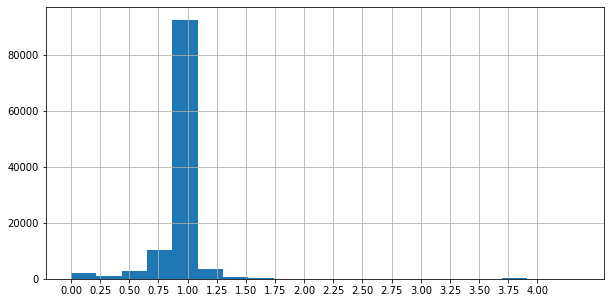

In [14]:
ax = df.occ_perc.hist(bins=20, figsize=(10,5))
ax = plt.xticks(np.linspace(0,4,17))

In [15]:
#Drop outliers
filtered = df[df['occ_perc'] > 1.4].groupby('program')['program'].agg(['count']) 

filtered = df.set_index(['program']).occ_perc.rename('>=1.4').ge(1.4)  \
  .groupby(level=[0]).value_counts(True).unstack(fill_value=0)

filtered.loc[['Family Residence - Main','Family Residence - TO site (Internal Referral Only)']] 

df = df[df.occ_perc < 1.4]

In [16]:
#pd.set_option('display.max_rows', 200) #shows 100 rows
#pd.reset_option('display.max_rows') #resets back to normal output
#unique_facility = df.groupby(['shelter','facility'])['facility'].agg(['count'])
#unique_facility
#most shelters have multiple facilities, seem to be at different addresses. Maybe remove shelter?

In [17]:
#unique_program = df.groupby(['program','facility'])['program'].agg(['count'])
#unique_program
#most programs are unique to facility maybe only need program?

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112206 entries, 111136 to 115915
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                112206 non-null  datetime64[ns]
 1   organization        112206 non-null  object        
 2   shelter             112206 non-null  object        
 3   address             112206 non-null  object        
 4   city                112206 non-null  object        
 5   prov                112206 non-null  object        
 6   postcode            106712 non-null  object        
 7   facility            112206 non-null  object        
 8   program             112206 non-null  object        
 9   sector              112206 non-null  object        
 10  occupancy           112206 non-null  int64         
 11  capacity            112206 non-null  float64       
 12  month               112206 non-null  int64         
 13  year                1122

In [19]:
df.sort_values(by='date', ascending=True, inplace=True)
df_ml = df.drop(['date','address','city','occupancy','prov','postcode','rain','snow','lat','long','organization','shelter','facility'], axis=1)#.replace([np.inf, -np.inf], np.nan).dropna()
df_ml

program  ... prior_day_occ_perc
64               Native Child & Family Services Toronto  ...           1.000000
60         Kennedy House Youth Shelter:  Bedded Program  ...           0.938462
14                              Family Residence - Main  ...           1.125000
58                 Homes First Society - Strachan House  ...           1.000000
81      Salvation Army - Florence Booth Womens Ministry  ...           0.750000
...                                                 ...  ...                ...
115911                           YWCA Davenport - Youth  ...           1.000000
115887              S.A. Evangeline - Emergency Weather  ...           1.000000
115822                   Robertson House - MAIN Program  ...           1.244444
115813                   Downsview Dells Bedded Program  ...           0.928571
115915                   YouthLink Transitional Program  ...           1.000000

[112206 rows x 14 columns]

# Exploratory Data Analysis

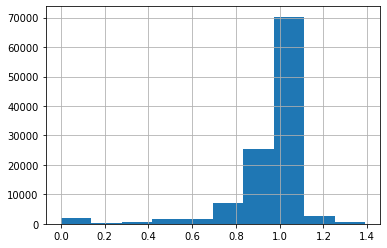

In [ ]:
#Look at distribution of percent capacity (note: Outliers removed earlier) 
df.occ_perc.hist()
#Often at or very near capacity, rarelyin some cases shelters appear to go over capacity

In [ ]:
#% of time shelters are full
df.full.mean()
#Shelters are full 57% of the time. Some slight imbalance but should be OK to proceed with traditional approaches

0.565789708215247

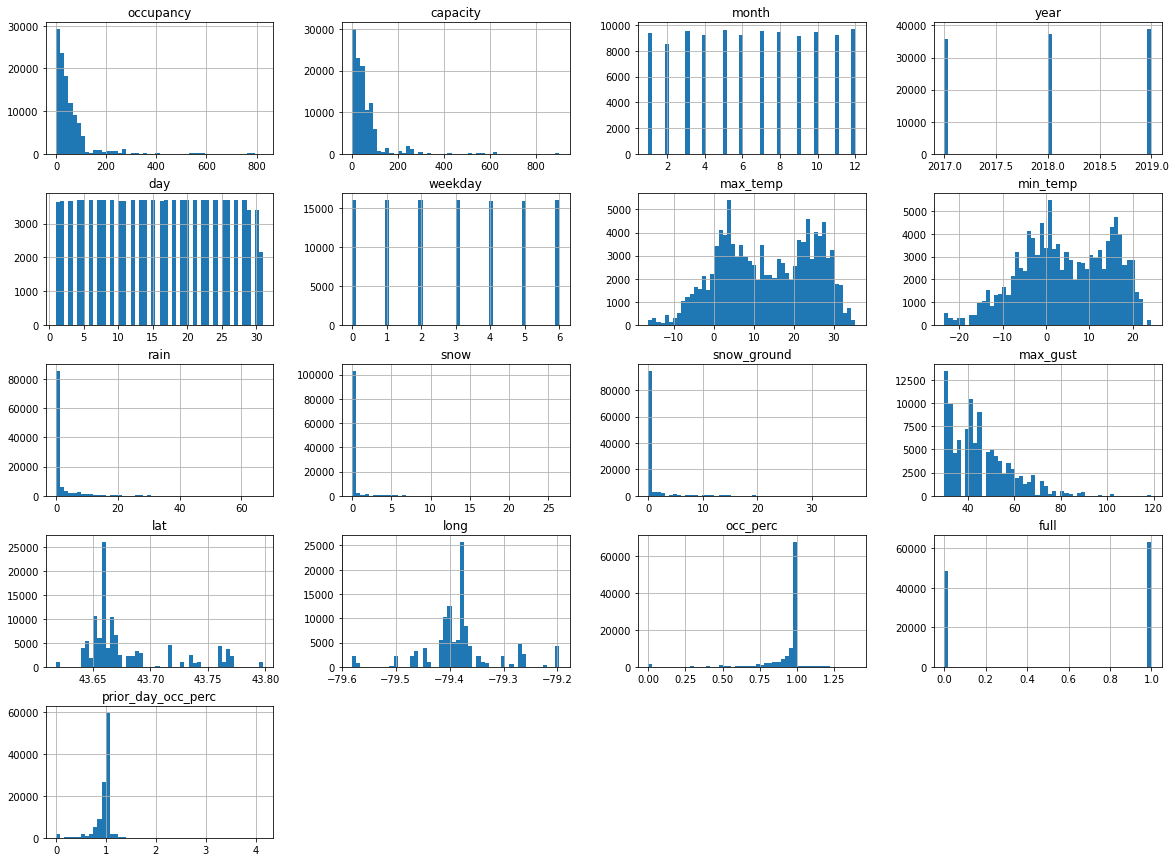

In [ ]:
#Look at distributions of numerical variables
df.hist(bins=50, figsize=(20,15))
plt.show()

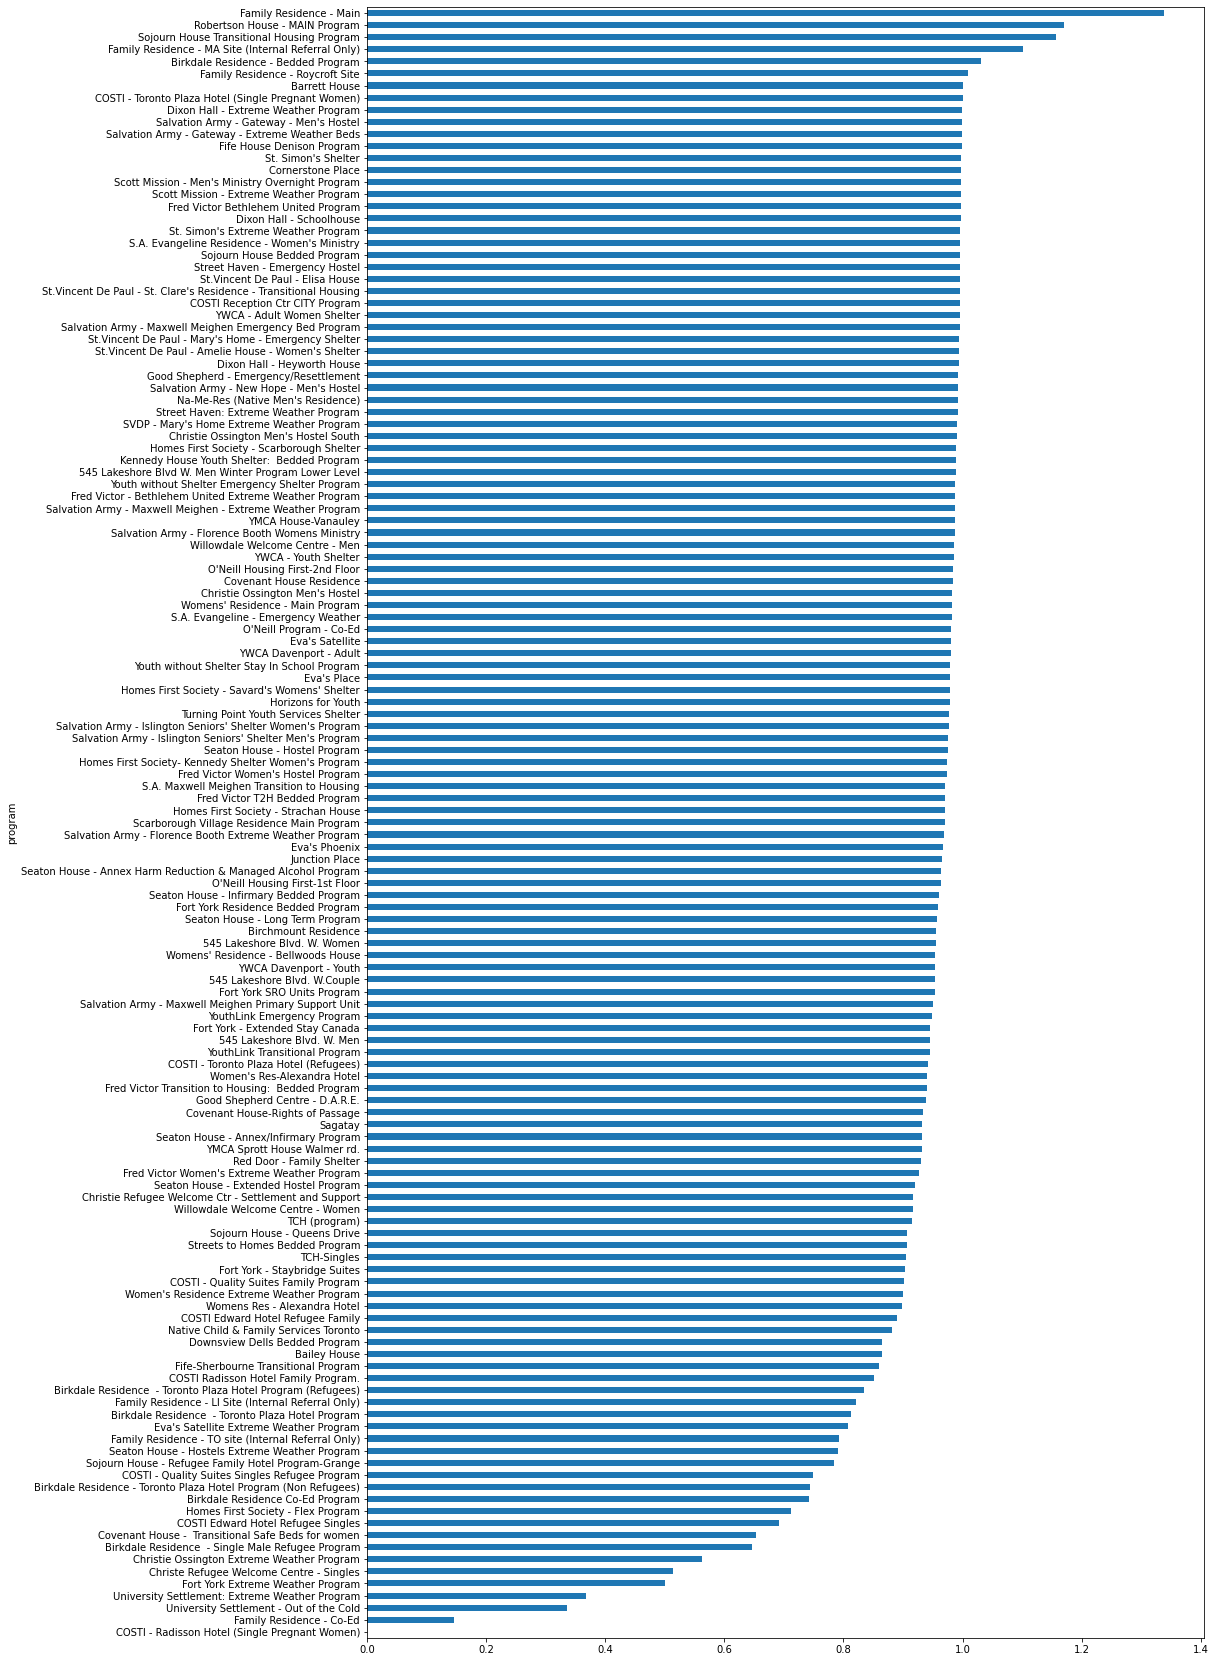

In [ ]:
#Look at and rank programs by average % occupancy 
df.groupby('program').occ_perc.mean().sort_values(ascending=True).plot.barh(figsize=(15,30))
#Most programs near occupancy on average

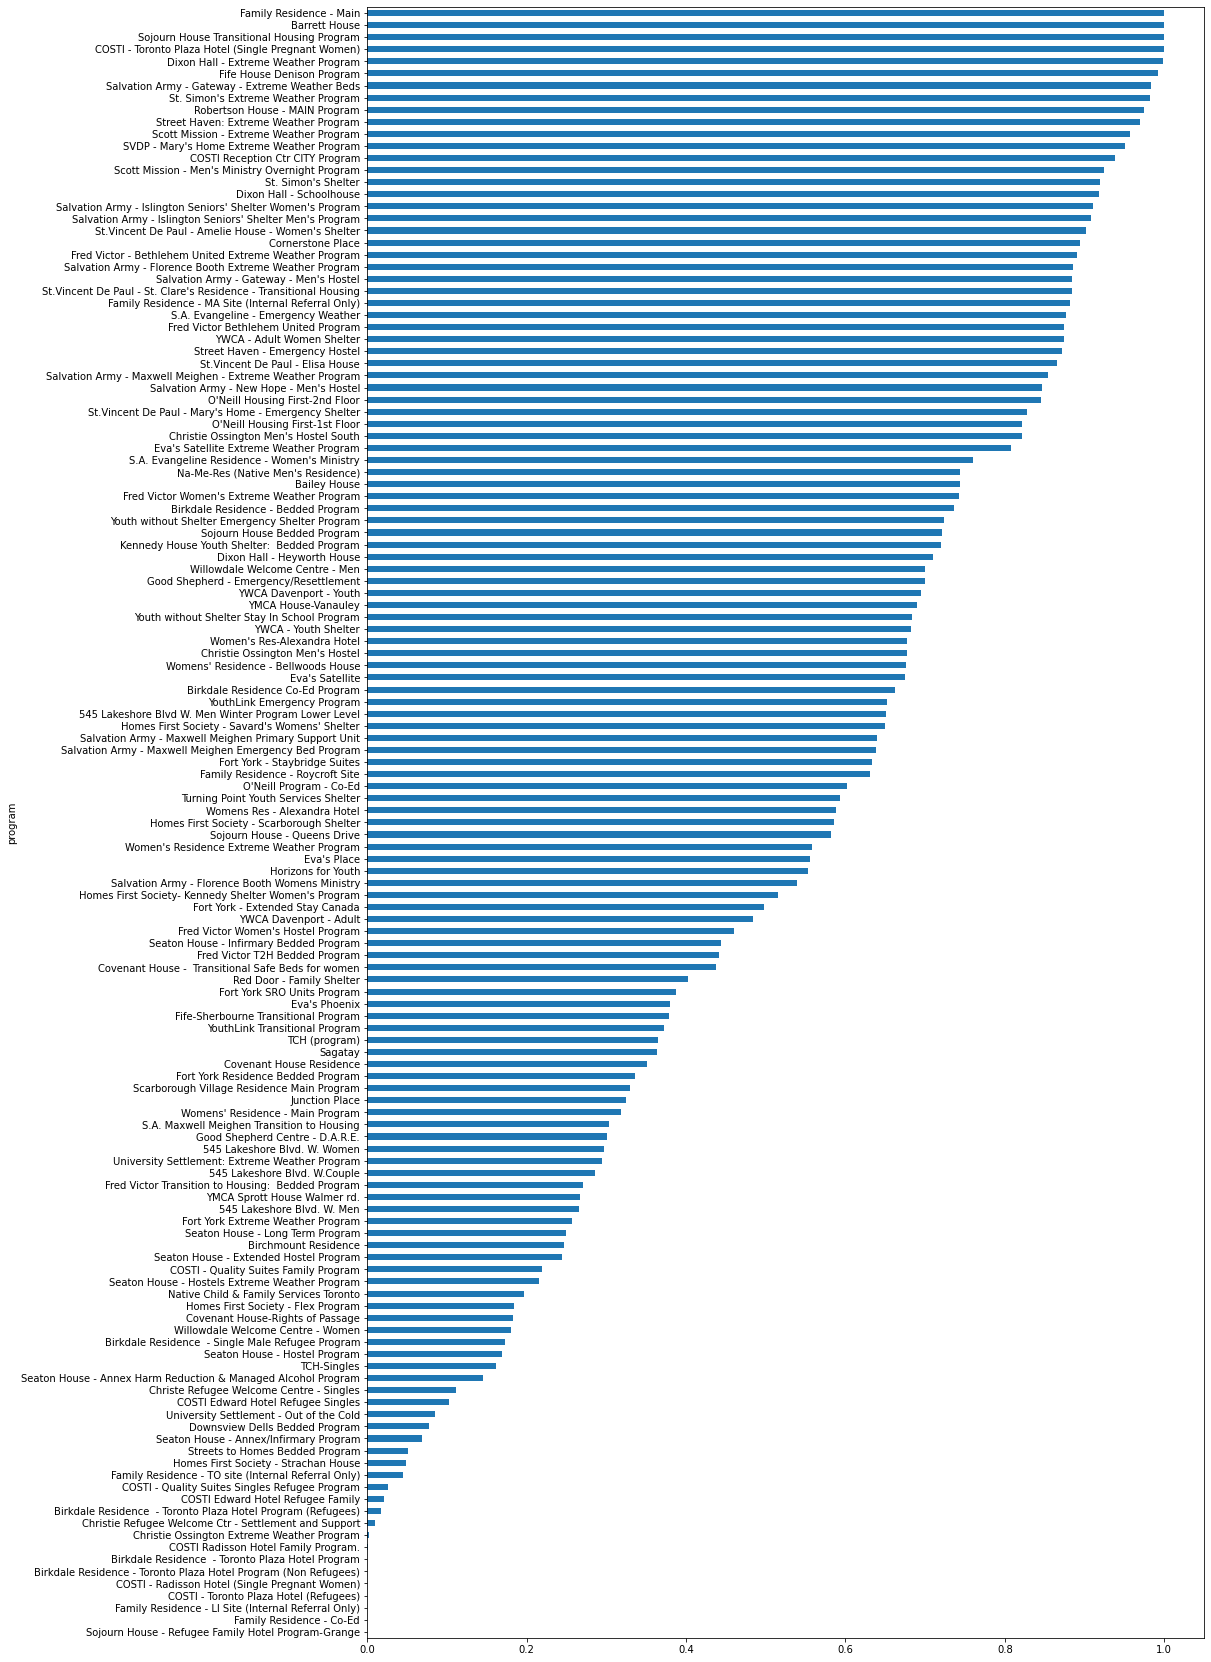

In [ ]:
#Look at % full by program
df.groupby('program').full.mean().sort_values(ascending=True).plot.barh(figsize=(15,30))
#Quite a range in how often programs are full

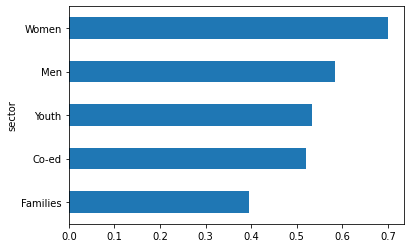

In [ ]:
#% full by program sector
df.groupby('sector').full.mean().sort_values(ascending=True).plot.barh()
#Women's programs tell to be full most often

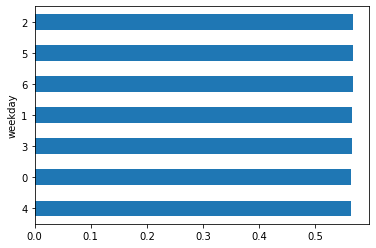

In [20]:
#% full by day of the week
df.groupby('weekday').full.mean().sort_values(ascending=True).plot.barh()
#No difference

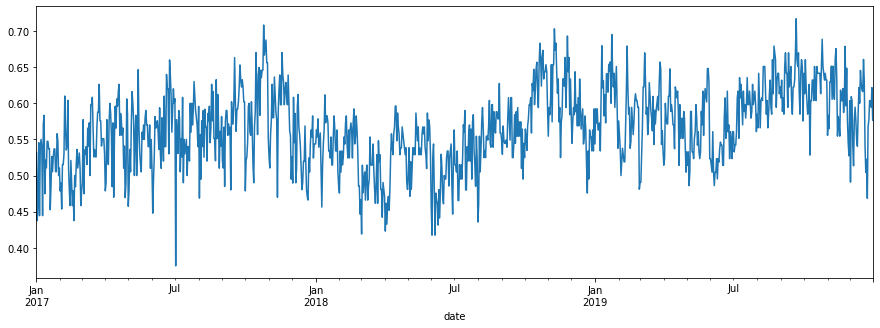

In [ ]:
#look at trend/seasonality in % full
df.groupby('date').full.mean().plot(figsize=(15,5))
#lower occupancy in summer, highest around November

numpy.ndarray

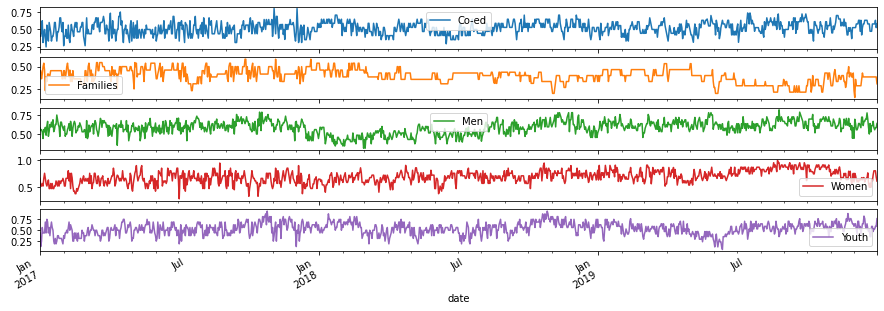

In [ ]:
#seasonality by program sector
axes = df.groupby(['date','sector']).full.mean().unstack().plot(figsize=(15,5),subplots=True)
type(axes)

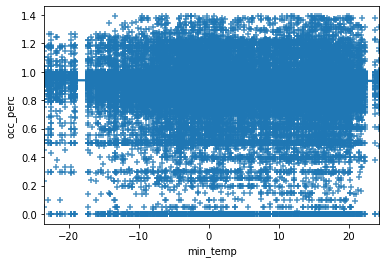

In [ ]:
#check if any clear relationship between temp and occ_perc, hard to tell but line looks flat
sns.regplot(x='min_temp', y='occ_perc', data=df, marker="+")

In [ ]:
#Look at shelters location in toronto, colour coded and sized by % full 

import plotly.express as px

df_map = df.groupby(['shelter','lat','long']).agg({'occ_perc': ['mean'],'full':['mean']})
# rename columns
df_map.columns = ['occ_perc_mean', 'full_mean']
# reset index to get grouped columns back
df_map = df_map.reset_index()

#px.scatter_geo(df_map, lat='lat', lon='long',size='full_mean', hover_name='shelter', text = 'occ_perc_mean', color='full_mean', color_continuous_scale = 'hot_r')

px.set_mapbox_access_token('pk.eyJ1Ijoiamdvb2R6OCIsImEiOiJja2hzanlhaGcwc25vMnhtam9rOTkyM3gxIn0.SGKwXjSu9-j0Mc5wUVJ9Qg')

fig = px.scatter_mapbox(df_map, lat="lat", lon="long", color="full_mean", size="full_mean", hover_name='shelter',
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

#Shelters in East Core tend to full most often

Text(0.5, 1.05, 'Feature Correlation Heatmap')

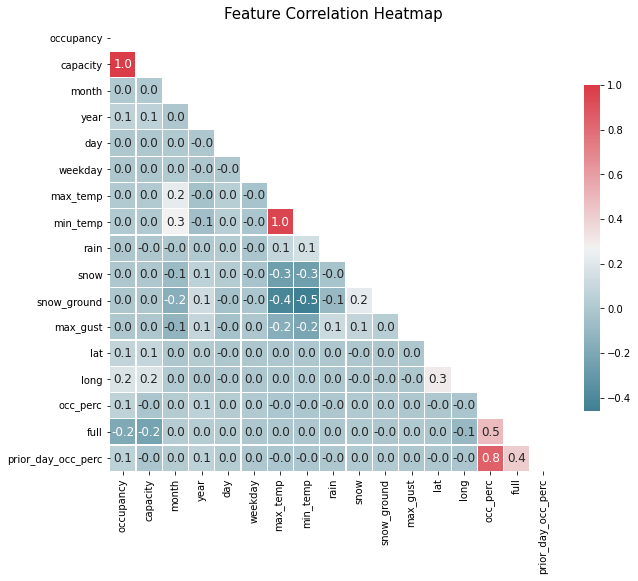

In [ ]:
#Look at correlation between variables
corr = df.corr()
    
_ , ax = plt.subplots(figsize =(10, 10))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
    
_ = sns.heatmap(round(corr,2), 
                cmap = colormap,
                square=True, 
                cbar_kws={'shrink':.6 }, 
                ax=ax,
                annot=True, 
                linewidths=0.1,vmax=1.0, linecolor='white',
                annot_kws={'fontsize':12 },
                fmt=".1f",
                mask=mask)
    
plt.title('Feature Correlation Heatmap', y=1.05, size=15)

# most correlation is within weather and between weather and months, not interesting
# Prior day occupancy highly correlated to occupancy the next day. Shelters with less occupancy have slightly higher chance of being full  


# Pipeline

In [21]:
from sklearn.model_selection import train_test_split
#split train and test sets
train_set, test_set = train_test_split(df_ml, test_size=0.4, random_state=123)
#Consider sort by date and take first 2/3, shuffle = false

# Separate Exploratory (X) from target (y)
X_train = train_set.drop(['occ_perc','full'], axis=1) # drop label for training set
y_train = train_set['full'].copy()

X_test = test_set.drop(['occ_perc','full'], axis=1)
y_test = test_set['full'].copy()


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# prepare data pipeline
# numerical values scaled using standard scaler and built in median imputer just in case despite no null values observed
num_X = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_X = X_train.select_dtypes(include=['object', 'bool']).columns
#date_X = X_train.select_dtypes(include=['datetime64[ns]']).columns

# create pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),                 
        ('std_scaler', StandardScaler()),
    ])

preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_X),
        ("cat", OneHotEncoder(), cat_X),
        #('date', SimpleImputer(), date_X)
    ])

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.fit_transform(X_test)
X_train_dense = X_train_prepared.todense()
X_test_dense = X_test_prepared.todense()

In [26]:
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(67323, 150)
(44883, 150)


In [ ]:
#could try PCA if more time

# Model Evaluation Functions

In [91]:
#General function to evaluate model performance

from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, recall_score

def evaluate_model(y_actual, y_pred, y_score):
 
 auc = roc_auc_score(y_actual, y_score)
 accuracy = accuracy_score(y_actual, y_pred)
 recall = recall_score(y_actual, y_pred)
 precision = precision_score(y_actual, y_pred)
 f1 = f1_score(y_actual, y_pred)
 prevalence = np.mean(y_actual)
 
 print('AUC:%.3f'%auc)
 print('accuracy:%.3f'%accuracy)
 print('recall:%.3f'%recall)
 print('precision:%.3f'%precision)
 print('f1:%.3f'%f1)
 print('prevalence:%.3f'%prevalence)
 print('')

In [29]:
#ROC Curve

from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    #plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


In [30]:
#Precision_recall_threshold chart

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0, 1])
    plt.grid(True)

In [31]:
#Precision Recall Curve

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])


In [32]:
#Get feature names after pipeline transformation
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer

def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names()]
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in


def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features

features = get_ct_feature_names(preprocessor)

# Training - No Skills Prediction

In [33]:
# generate a no skill prediction (majority class)
ns_probs = [1 for _ in range(len(y_train))]

In [34]:
from sklearn.metrics import roc_curve
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train,ns_probs)

# Training: Random-Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=123, oob_score=True)

In [ ]:
# fit untuned random forecast classifier
forest_clf.fit(X_train_prepared, y_train)
print(forest_clf.oob_score_)

0.8624541390015299


In [ ]:
#check fit on train set
from sklearn.metrics import accuracy_score
y_forest_pred = forest_clf.predict(X_train_prepared)
accuracy_score(y_train, y_forest_pred)
# overfitting

0.9999851462353133

In [ ]:
#time-series cross-validation accuracy pre tuning for reference
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(forest_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

array([0.86048723, 0.8620915 , 0.86256684])

In [ ]:
#Time series based hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest (default = 100)
n_estimators = [100, 500, 1000]
# Number of features to consider at every split (default = 'auto')
max_features = ['sqrt'] #, 'auto']
# Maximum number of levels in tree (default = None, unlimited)
max_depth = [100, None]
# Minimum number of samples required to split a node (default = 2)
min_samples_split = [2, 10]
# Minimum number of samples required at each leaf node (default = 1)
min_samples_leaf = [1, 5]
# Number of leaf nodes (default = None, unlimited )
max_leaf_nodes = [10, None]
# Method of selecting samples for training each tree
bootstrap = [True] #,False]

#Create timeseries cv 
tscv = TimeSeriesSplit(n_splits=3)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(RandomForestClassifier(), param_distributions=random_grid, n_iter=15, cv=tscv, verbose=2, random_state=123, scoring='accuracy', n_jobs=1) #n_jobs=-1, pre_dispatch='2*n_jobs')
rf_random.fit(X_train_prepared, y_train)
print(rf_random.best_params_)
print(rf_random.best_score_)
forest_clf = rf_random.best_estimator_
#/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
#  "timeout or by a memory leak.", UserWarning <- error when using n_jobs = -1

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total= 1.3min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total= 3.1min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total= 5.3min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=None, bootstrap=True, total=  58.8s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=None, bootstrap=True, total= 2.4min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_esti

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 74.1min finished


{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
0.8640720934838582


In [ ]:
rf_random.cv_results_

{'mean_fit_time': array([189.46682779, 146.65725811,  14.81711761,  14.58408189,
         18.98693212, 147.39412244,  72.83233444, 146.13878775,
         94.90202181,  18.86259007, 145.94776217,  29.96010947,
         96.0967919 ,  14.83524307, 301.61476564]),
 'mean_score_time': array([3.90197778, 3.30828102, 0.33486462, 0.32818739, 0.39742565,
        3.32025409, 1.64320588, 3.29907982, 1.9484005 , 0.390402  ,
        3.27101668, 0.43854094, 2.04313318, 0.33404422, 4.58773907]),
 'mean_test_score': array([0.86407209, 0.86090315, 0.86092296, 0.86048723, 0.86391365,
        0.86044761, 0.86098237, 0.86086354, 0.8637552 , 0.86306199,
        0.86078431, 0.86022975, 0.86379481, 0.8600713 , 0.86161616]),
 'param_bootstrap': masked_array(data=[True, True, True, True, True, True, True, True, True,
                    True, True, True, True, True, True],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, F

In [35]:
#selected 5th run for best combination of accuracy and speed
forest_clf = RandomForestClassifier(random_state=123, max_features='sqrt', min_samples_split=10)
forest_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [37]:
#evaluate tuned model
from sklearn.model_selection import cross_val_predict

y_forest_pred = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3)
y_probas_forest = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3, method="predict_proba")
y_forest_scores = y_probas_forest[:, 1]
evaluate_model(y_train, y_forest_pred, y_forest_scores)

AUC:0.935
accuracy:0.865
recall:0.913
precision:0.857
f1:0.884
prevalence:0.566



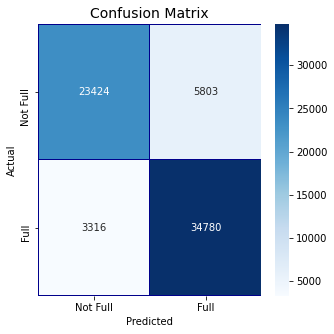

In [38]:
#Generate confusion matrix to see comparison of predicated vs actual values  

cm = pd.crosstab(y_train, y_forest_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

#mistakes tend to be to predict 'full' when not full

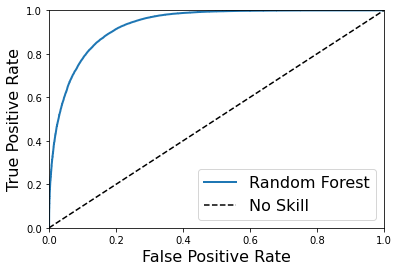

In [39]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)
   
#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

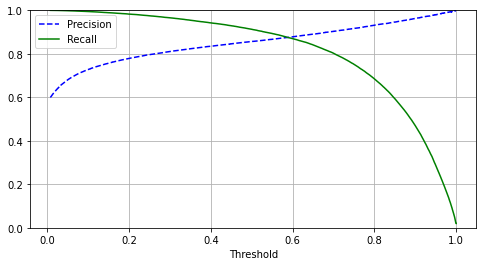

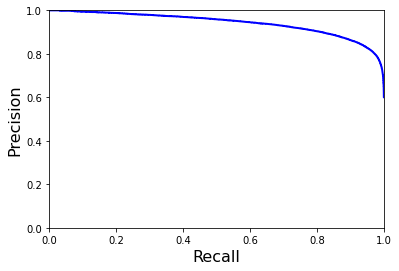

In [40]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train,y_forest_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve
  
plot_precision_vs_recall(precisions, recalls)
plt.show()
#If city is low on resources, could consider increase to 0.6 to improve precision (how often we are correct, minimize risk of creating new capacity for no reason) but as some cost to recall (missing opening extra capacity when needed)
#If city has some additional capacity, could consider lowering threshold to 0.2 which would catch almost all times the shelters are full while still keeping about 80% precision (i.e. very low chance of not having shelter for someone that needs it but opening up extra capacity about 20% of the time instead of 14% with current threshold)

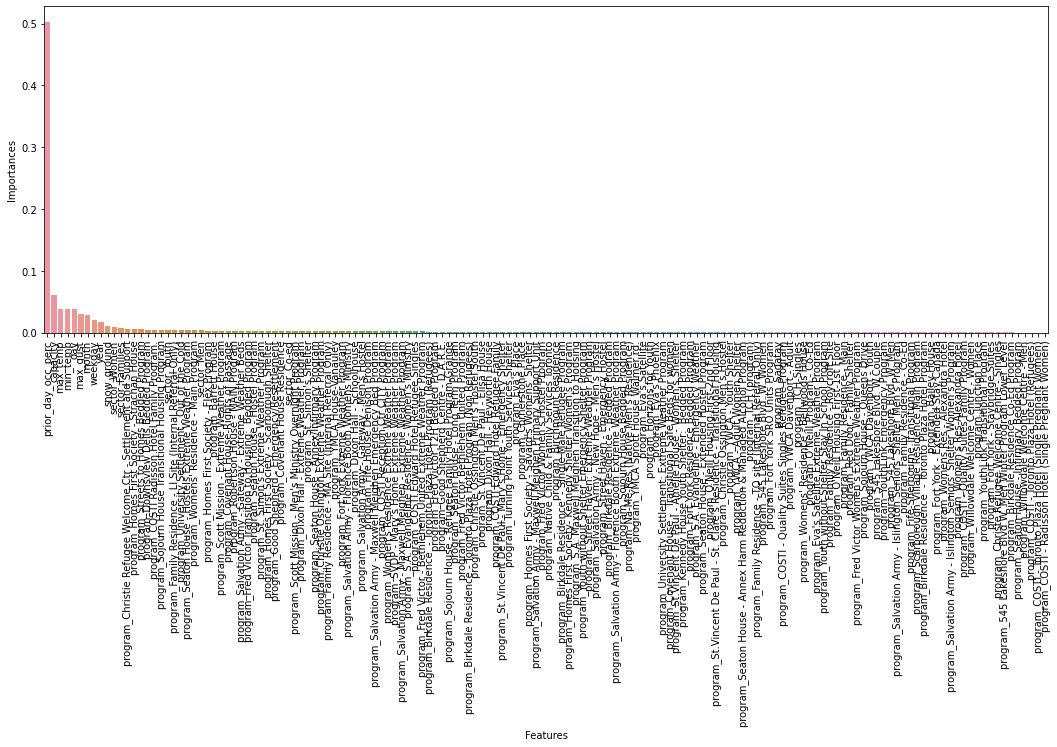

Features  Importances
9                                   prior_day_occ_perc     0.502674
0                                             capacity     0.061128
5                                             max_temp     0.038192
6                                             min_temp     0.037955
3                                                  day     0.037860
..                                                 ...          ...
108    program_Seaton House - Infirmary Bedded Program     0.000075
128            program_Willowdale Welcome Centre - Men     0.000046
26      program_COSTI - Toronto Plaza Hotel (Refugees)     0.000011
27   program_COSTI - Toronto Plaza Hotel (Single Pr...     0.000011
25   program_COSTI - Radisson Hotel (Single Pregnan...     0.000004

[150 rows x 2 columns]

In [ ]:
#Look at feature importances (need to get columns from df)

def feature_importances(clf, X, figsize=(18, 6)):
    importances = pd.DataFrame({'Features': features, 
                                'Importances': clf.feature_importances_})
    
    importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

    fig = plt.figure(figsize=figsize)
    sns.barplot(x='Features', y='Importances', data=importances)
    plt.xticks(rotation='vertical')
    plt.show()
    return importances

feature_importances(forest_clf, X_train_prepared) 

# Training: KNN Classifier

In [ ]:
# fit untuned random forecast classifier
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_prepared, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
#check fit on train set
from sklearn.metrics import accuracy_score
y_knn_pred = Knn_clf.predict(X_train_prepared)
accuracy_score(y_train, y_knn_pred)

0.8762384326307503

In [ ]:
#time-series cross-validation accuracy pre tuning for reference
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(knn_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

array([0.78514557, 0.80386215, 0.8130719 ])

In [ ]:
#Time series based hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier

# Number of neighbors (default = 5)
n_neighbors = [5,8,10]
# Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem (default = 30)
leaf_size = [1,10,30,40]
# weight function used in prediction (default = uniform)
weights = ['uniform', 'distance']
# Algorithm used to compute the nearest neighbors (default = auto, attempts to decide most appropriate)
algorithm = ['auto', 'ball_tree','kd_tree','brute']
#Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
p = [1,2]
# Minimum number of samples required at each leaf node (default = 1)
n_jobs = [-1]

#Create timeseries cv 
tscv = TimeSeriesSplit(n_splits=3)

# Create the random grid
random_grid = {'n_neighbors':n_neighbors,
          'leaf_size':leaf_size,
          'weights': weights,
          'algorithm':algorithm,
          'p': p,
          'n_jobs':n_jobs}

knn_random = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=random_grid, n_iter=20, cv=tscv, verbose=2, random_state=123, scoring='accuracy', n_jobs=1) #n_jobs=-1, pre_dispatch='2*n_jobs')
knn_random.fit(X_train_prepared, y_train)
print(knn_random.best_params_)
print(knn_random.best_score_)
knn_clf = knn_random.best_estimator_
#left error from forgetting to rename, too slow to re-run

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute, total=  32.8s
[CV] weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.8s remaining:    0.0s


[CV]  weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute, total= 1.3min
[CV] weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute 
[CV]  weights=uniform, p=1, n_neighbors=8, n_jobs=-1, leaf_size=30, algorithm=brute, total= 1.9min
[CV] weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto 
[CV]  weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto, total=  45.1s
[CV] weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto 
[CV]  weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto, total= 1.0min
[CV] weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto 
[CV]  weights=uniform, p=2, n_neighbors=5, n_jobs=-1, leaf_size=30, algorithm=auto, total= 1.3min
[CV] weights=distance, p=1, n_neighbors=8, n_jobs=-1, leaf_size=40, algorithm=auto 
[CV]  weights=distance, p=1, n_neighbors=8, n_jobs=-1, leaf_size=40, algorithm=auto, total=

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 73.8min finished


NameError: ignored

In [ ]:
knn_random.cv_results_

{'mean_fit_time': array([0.03330493, 2.5460511 , 2.56806016, 3.00598224, 2.41113091,
        2.51027425, 2.348761  , 0.02699526, 2.48257343, 2.49685152,
        2.95386195, 0.02875566, 0.02913721, 2.77206341, 2.53670684,
        0.0286351 , 2.7518905 , 2.38855124, 0.02853147, 0.0276773 ]),
 'mean_score_time': array([ 74.78474347,  58.30168192,  87.01352286, 131.06824875,
        114.17802278,  69.26898122, 103.61064585,  26.06123845,
         38.27314838, 126.92865841,  71.36040489,  25.7535104 ,
         25.34630545,  67.69864798, 110.47973466,  70.29943673,
         82.71492235, 109.42959023,  25.23459737,  25.14873171]),
 'mean_test_score': array([0.79578134, 0.7929689 , 0.80013864, 0.7956427 , 0.79063181,
        0.79427609, 0.79302832, 0.7929689 , 0.80013864, 0.79560309,
        0.80027728, 0.79134482, 0.79455338, 0.79120618, 0.79465241,
        0.79578134, 0.7956427 , 0.80017825, 0.80069321, 0.80031689]),
 'param_algorithm': masked_array(data=['brute', 'auto', 'auto', 'auto', 'ba

In [ ]:
print(knn_random.best_params_)
print(knn_random.best_score_)
knn_clf = knn_random.best_estimator_
#about the same accuracy but faster

{'weights': 'distance', 'p': 2, 'n_neighbors': 10, 'n_jobs': -1, 'leaf_size': 1, 'algorithm': 'brute'}
0.8006932065755595


In [41]:
knn_clf = KNeighborsClassifier(n_neighbors=10, algorithm='brute', weights='distance')
knn_clf.fit(X_train_prepared, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

In [42]:
#evaluate tuned model
from sklearn.model_selection import cross_val_predict

y_knn_pred = cross_val_predict(knn_clf, X_train_prepared, y_train, cv=3)
y_probas_knn = cross_val_predict(knn_clf, X_train_prepared, y_train, cv=3, method="predict_proba")
y_knn_scores = y_probas_knn[:, 1]
evaluate_model(y_train, y_knn_pred, y_knn_scores)

AUC:0.881
accuracy:0.809
recall:0.901
precision:0.791
f1:0.843
prevalence:0.566



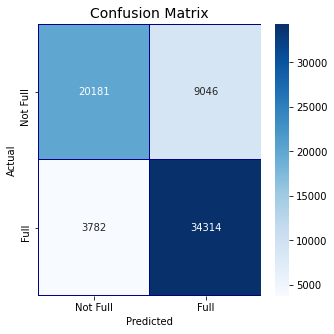

In [ ]:
cm = pd.crosstab(y_train, y_knn_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

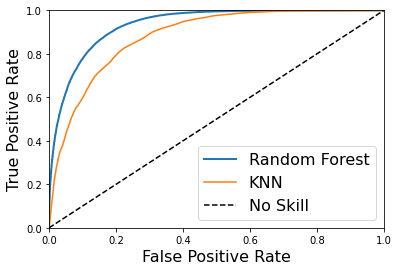

In [43]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_knn_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)
   
#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_knn, tpr_knn, label= "KNN")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

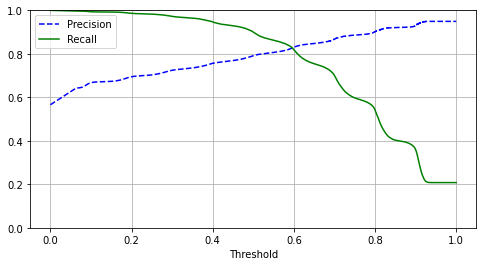

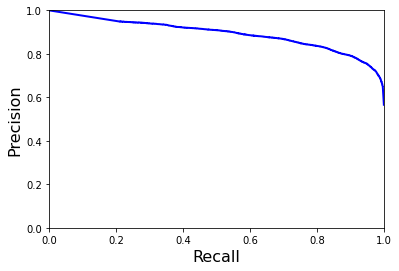

In [44]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train,y_knn_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve
   
plot_precision_vs_recall(precisions, recalls)
plt.show()
#If city is low on resources, could consider increase to 0.6 to improve precision (how often we are correct, minimize risk of creating new capacity for no reason) but as some cost to recall (missing opening extra capacity when needed)
#If city has some additional capacity, could consider lowering threshold to 0.2 which would catch almost all times the shelters are full while still keeping about 80% precision (i.e. very low chance of not having shelter for someone that needs it but opening up extra capacity about 20% of the time instead of 14% with current threshold)

# Training: SGD Log Classifier

In [ ]:
# fit untuned SGD Log classifier
from sklearn.linear_model import SGDClassifier

log_clf = SGDClassifier(loss='log', random_state=123)
log_clf.fit(X_train_prepared, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
#check fit on train set
from sklearn.metrics import accuracy_score
y_log_pred = log_clf.predict(X_train_prepared)
accuracy_score(y_train, y_log_pred)

0.8350340893899559

In [ ]:
#time-series cross-validation accuracy pre tuning for reference
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(log_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

array([0.8295306 , 0.833571  , 0.83161022])

In [ ]:
#Time series based hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform
from sklearn.linear_model import SGDClassifier

#The penalty (aka regularization term) to be used. Defaults to ‘l2’ which is the standard regularizer for linear SVM models. ‘l1’ and ‘elasticnet’ might bring sparsity to the model (feature selection) not achievable with ‘l2’.
penalty = ['l2', 'l1', 'elasticnet']

#Constant that multiplies the regularization term. The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’ (default=0.0001).
alpha = [0.000001, 0.0001, 0.01]

#The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1. Only used if penalty is ‘elasticnet’ (default=0.15)
l1_ratio = [0.05, 0.15, 0.5]

#Whether the intercept should be estimated or not. If False, the data is assumed to be already centered (default=True).
fit_intercept = [True]

#The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method, and not the partial_fit method (default=1000).
max_iter = [500, 1000, 5000] 

#The stopping criterion. If it is not None, training will stop when (loss > best_loss - tol) for n_iter_no_change consecutive epochs (default=1e-3)
tol = [1e-3]

#Number of iterations with no improvement to wait before early stopping (default=5).
n_iter_no_change = [5, 20]

#Whether or not the training data should be shuffled after each epoch (default=True).
shuffle = [True, False]

#The learning rate schedul (default=’optimal’)
learning_rate = ['optimal', 'adaptive', 'invscaling']

#The initial learning rate for the ‘constant’, ‘invscaling’ or ‘adaptive’ schedules. The default value is 0.0 as eta0 is not used by the default schedule ‘optimal’.
eta0 = [0.01, 1, 10]

#Whether to use early stopping to terminate training when validation score is not improving (default=False)
early_stopping = [True, False]

#The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True (default=0.1)
validation_fraction = [0.1, 0.3] 

#Create timeseries cv 
tscv = TimeSeriesSplit(n_splits=3)

# Create the random grid
random_grid = {'penalty':penalty,
          'alpha':alpha,
          'l1_ratio': l1_ratio,
          'fit_intercept': fit_intercept,
          'max_iter':max_iter,
          'tol': tol,
          'n_iter_no_change': n_iter_no_change,
          'shuffle': shuffle,
          'learning_rate': learning_rate,
          'eta0': eta0,
          'early_stopping': early_stopping,
          'validation_fraction': validation_fraction
          }

log_randsearch = RandomizedSearchCV(SGDClassifier(loss='log', random_state=123), param_distributions=random_grid, n_iter=1500, cv=tscv, verbose=2, scoring='accuracy', n_jobs=-1, pre_dispatch='2*n_jobs')
log_randsearch.fit(X_train_prepared, y_train)
print(log_randsearch.best_params_)
print(log_randsearch.best_score_)
log_clf = log_randsearch.best_estimator_

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed: 38.6min finished


{'validation_fraction': 0.3, 'tol': 0.001, 'shuffle': False, 'penalty': 'elasticnet', 'n_iter_no_change': 5, 'max_iter': 5000, 'learning_rate': 'invscaling', 'l1_ratio': 0.15, 'fit_intercept': True, 'eta0': 1, 'early_stopping': False, 'alpha': 0.0001}
0.8435135670429789


In [ ]:
log_randsearch.cv_results_

{'mean_fit_time': array([0.24168054, 0.1253744 , 1.21979197, ..., 0.3720475 , 0.55423657,
        0.69346905]),
 'mean_score_time': array([0.00449888, 0.00372458, 0.00412472, ..., 0.003872  , 0.0039022 ,
        0.00326896]),
 'mean_test_score': array([0.83269954, 0.81738958, 0.79510794, ..., 0.75777382, 0.83242226,
        0.84058229]),
 'param_alpha': masked_array(data=[0.0001, 0.0001, 1e-06, ..., 0.0001, 1e-06, 1e-06],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_early_stopping': masked_array(data=[False, True, False, ..., False, False, True],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_eta0': masked_array(data=[10, 0.01, 0.01, ..., 0.01, 10, 0.01],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[True, Tru

In [ ]:
print(log_randsearch.best_params_)
print(log_randsearch.best_score_)
log_clf = log_randsearch.best_estimator_
#about the same accuracy but faster

{'validation_fraction': 0.3, 'tol': 0.001, 'shuffle': False, 'penalty': 'elasticnet', 'n_iter_no_change': 5, 'max_iter': 5000, 'learning_rate': 'invscaling', 'l1_ratio': 0.15, 'fit_intercept': True, 'eta0': 1, 'early_stopping': False, 'alpha': 0.0001}
0.8435135670429789


In [45]:
log_clf = SGDClassifier(loss='log', validation_fraction=0.3, penalty='elasticnet', shuffle=False, max_iter=5000, learning_rate='invscaling', eta0=1, random_state=123)
log_clf.fit(X_train_prepared, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='invscaling', loss='log',
              max_iter=5000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=123,
              shuffle=False, tol=0.001, validation_fraction=0.3, verbose=0,
              warm_start=False)

In [46]:
#evaluate tuned model
from sklearn.model_selection import cross_val_predict

y_log_pred = cross_val_predict(log_clf, X_train_prepared, y_train, cv=3)
y_probas_log = cross_val_predict(log_clf, X_train_prepared, y_train, cv=3, method="predict_proba")
y_log_scores = y_probas_log[:, 1]
evaluate_model(y_train, y_log_pred, y_log_scores)

AUC:0.909
accuracy:0.841
recall:0.906
precision:0.829
f1:0.866
prevalence:0.566



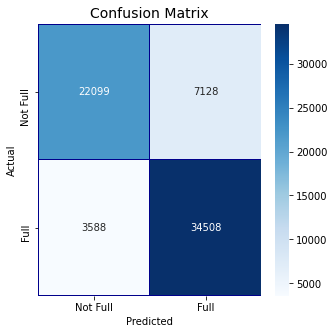

In [ ]:
cm = pd.crosstab(y_train, y_log_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

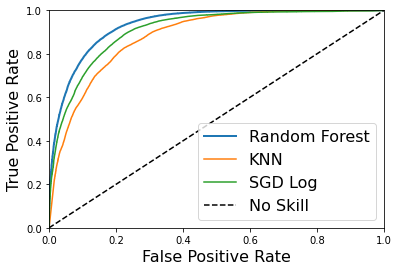

In [47]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_knn_scores)

#for SGD log
fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_log_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)

#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_knn, tpr_knn, label = "KNN")
plt.plot(fpr_log, tpr_log, label = "SGD Log")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

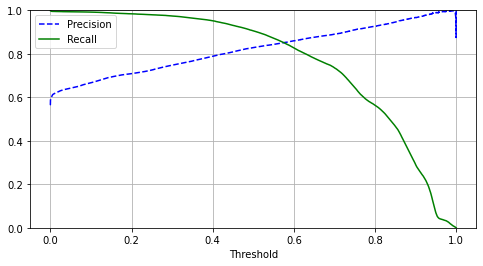

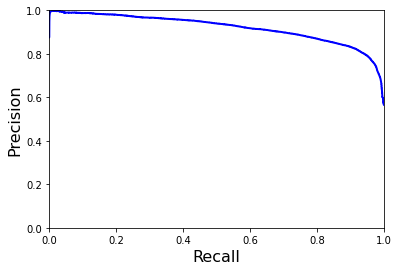

In [48]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train,y_log_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve

plot_precision_vs_recall(precisions, recalls)
plt.show()

# Training: Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=123)
tree_clf.fit(X_train_prepared, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [ ]:
#check fit on train set
from sklearn.metrics import accuracy_score
y_tree_pred = tree_clf.predict(X_train_prepared)
accuracy_score(y_train, y_tree_pred)
# overfitting

1.0

In [ ]:
#time-series cross-validation accuracy pre tuning for reference
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(tree_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

array([0.80540701, 0.80118835, 0.81277481])

In [ ]:
#Time series based hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform
from sklearn.tree import DecisionTreeClassifier

# The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain (default = gini)
criterion = ["gini", "entropy"]
# The number of features to consider when looking for the best split (default = None = n_features  )
max_features = ['sqrt', 'auto'] 
# Maximum number of levels in tree (default = None, unlimited)
max_depth = [25, 50, 100, None]
# Minimum number of samples required to split a node (default = 2)
min_samples_split = [2, 5, 20]
# Minimum number of samples required at each leaf node (default = 1)
min_samples_leaf = [1, 20, 50]
# Number of leaf nodes (default = None, unlimited )
max_leaf_nodes = [10, 100, None]
# A node will be split if this split induces a decrease of the impurity greater than or equal to this value (default = 0)
#min_impurity_decrease = [0]

#Create timeseries cv 
tscv = TimeSeriesSplit(n_splits=3)

# Create the random grid
param_grid = {"criterion": criterion,
              "max_features": max_features,
              "max_depth": max_depth,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              "max_leaf_nodes": max_leaf_nodes,
             }

tree_gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid=param_grid, cv=tscv, verbose=2, scoring='accuracy', n_jobs=1) #n_jobs=-1, pre_dispatch='2*n_jobs')
tree_gridsearch.fit(X_train_prepared, y_train)
print(tree_gridsearch.best_params_)
print(tree_gridsearch.best_score_)
tree_clf = tree_gridsearch.best_estimator_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=5 
[CV]  criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=5, total=   0.0s
[CV] criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=5 
[CV]  criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=5 
[CV]  criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=5, total=   0.2s
[CV] criterion=gini, max_depth=25, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=20 
[CV]  criterion=gini, max_d

[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed:  3.0min finished


{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 2}
0.8474351356704298


In [ ]:
tree_gridsearch.cv_results_

{'mean_fit_time': array([0.08168681, 0.0842847 , 0.07841404, 0.08126783, 0.08222151,
        0.08183924, 0.08361387, 0.08242273, 0.08298779, 0.13598235,
        0.13795439, 0.13247236, 0.13830098, 0.13251114, 0.13632703,
        0.1332798 , 0.13970534, 0.1344498 , 0.14241552, 0.14372238,
        0.13639673, 0.13686148, 0.13027946, 0.13660002, 0.13210622,
        0.13303463, 0.13342746, 0.08305852, 0.08480509, 0.0802575 ,
        0.07908201, 0.08173426, 0.08185609, 0.08212431, 0.08058858,
        0.08160424, 0.13194474, 0.13653469, 0.13851039, 0.13555447,
        0.13578693, 0.13282537, 0.13393227, 0.1362861 , 0.13364236,
        0.14346433, 0.14059114, 0.14001155, 0.1313196 , 0.13692411,
        0.13243898, 0.13145693, 0.1359787 , 0.13423642, 0.08897169,
        0.08294026, 0.08365186, 0.08237267, 0.08147152, 0.08320999,
        0.08383314, 0.08348179, 0.08378069, 0.14383173, 0.14219721,
        0.1412584 , 0.14656536, 0.14194735, 0.13765136, 0.13893787,
        0.13713257, 0.14092104,

In [49]:
tree_clf = DecisionTreeClassifier(random_state=123, max_depth=50, max_features='sqrt', min_samples_leaf=20)
tree_clf.fit(X_train_prepared, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [50]:
#evaluate tuned model
from sklearn.model_selection import cross_val_predict

y_tree_pred = cross_val_predict(tree_clf, X_train_prepared, y_train, cv=3)
y_probas_tree = cross_val_predict(tree_clf, X_train_prepared, y_train, cv=3, method="predict_proba")
y_tree_scores = y_probas_tree[:, 1]
evaluate_model(y_train, y_tree_pred, y_tree_scores)

AUC:0.909
accuracy:0.846
recall:0.884
precision:0.850
f1:0.866
prevalence:0.566



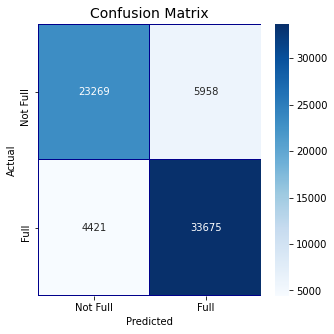

In [ ]:
cm = pd.crosstab(y_train, y_tree_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

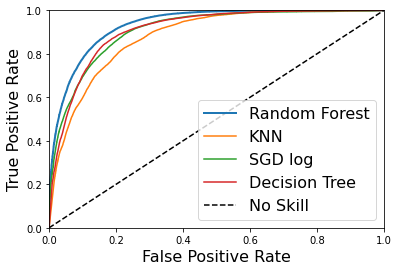

In [51]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_knn_scores)

#for SGD log
fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_log_scores)

#for tree
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_train, y_tree_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)
    
#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_knn, tpr_knn, label="KNN")
plt.plot(fpr_log, tpr_log, label="SGD log")
plt.plot(fpr_tree, tpr_tree, label="Decision Tree")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

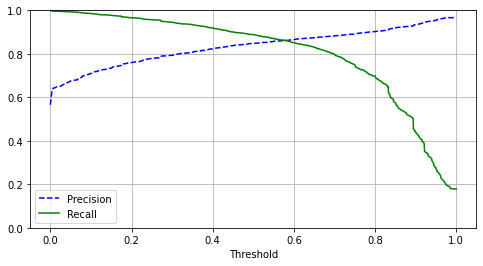

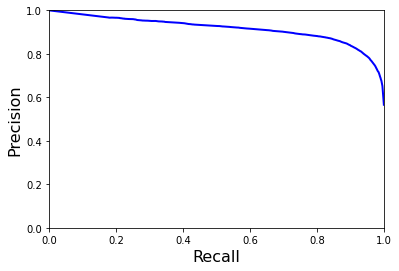

In [52]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train,y_tree_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [ ]:
tree_clf.classes_

array([0, 1])

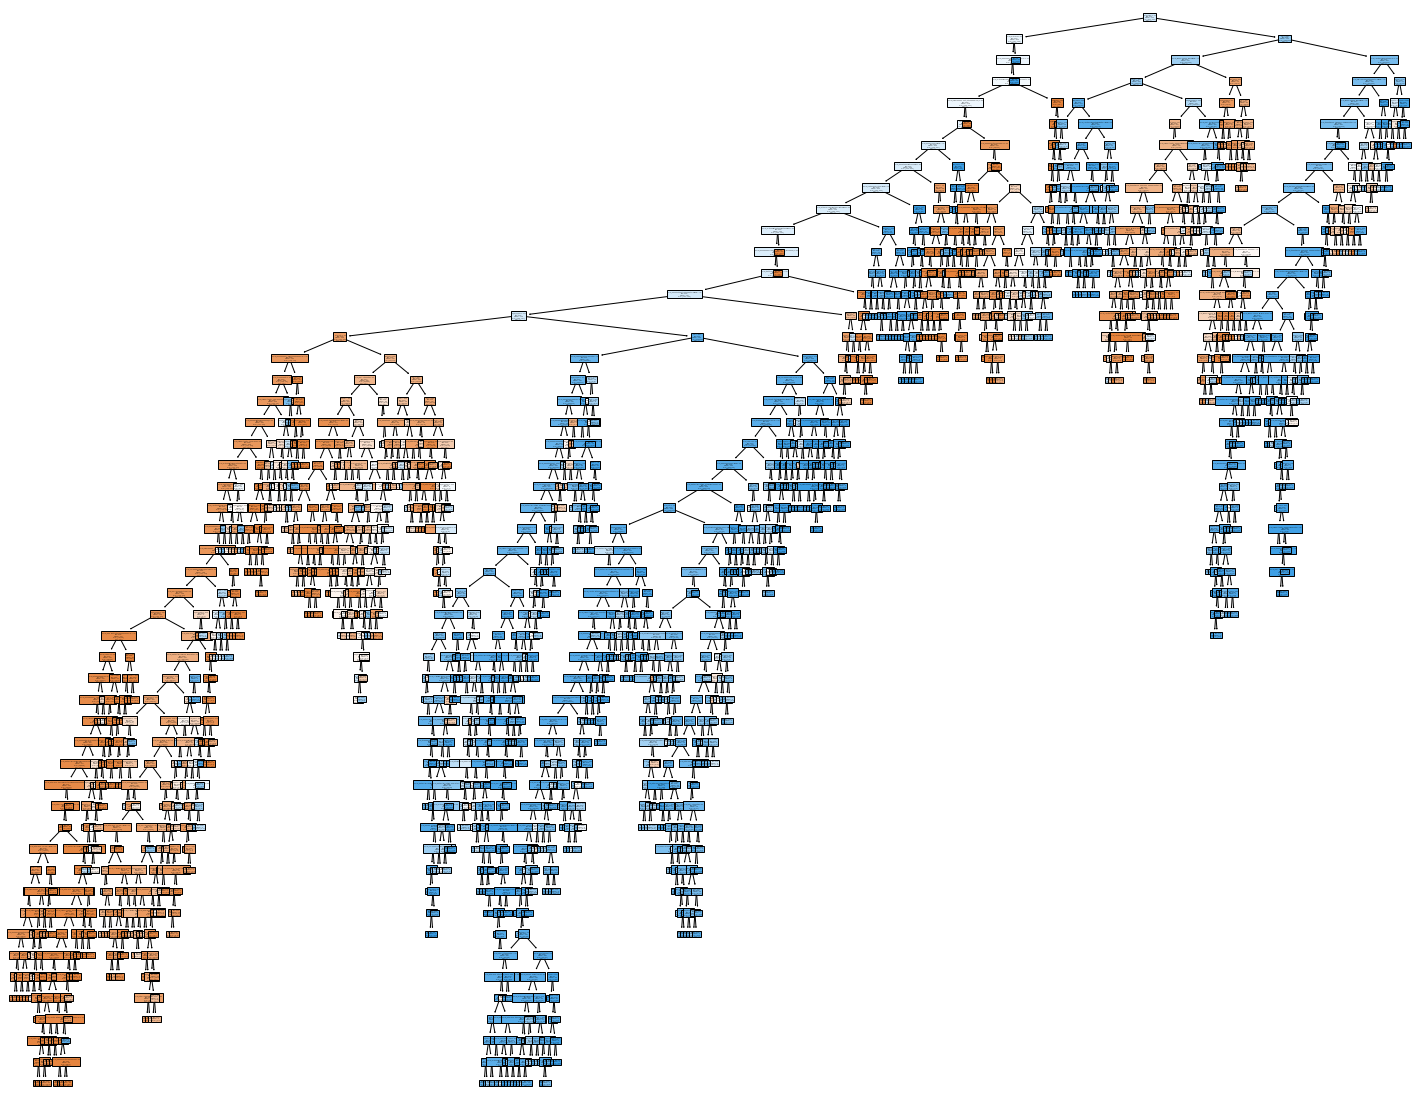

In [ ]:
#https://mljar.com/blog/visualize-decision-tree/
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz
#from IPython.display import Image 
#import pydotplus

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_clf, 
                   feature_names=features,  
                   class_names=['not full', 'full'],
                   filled=True)

# Create PNG
#fig.savefig("decistion_tree.png")


# With graphviz more zoomed view:

# DOT data
#dot_data = tree.export_graphviz(tree_clf, out_file=None, 
#                                feature_names=features,  
#                                class_names=['not full', 'full'],
#                                filled=True)

# Draw graph
#graph = graphviz.Source(dot_data, format="png") 
#graph

# Training: Naive Bayes Classifier

In [23]:
#Fit NB model
from sklearn.naive_bayes import GaussianNB

NB_clf = GaussianNB()
NB_clf.fit(X_train_dense, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [124]:
#evaluate NB model
from sklearn.model_selection import cross_val_predict

y_NB_pred = cross_val_predict(NB_clf, X_train_dense, y_train, cv=3)
y_probas_NB = cross_val_predict(NB_clf, X_train_dense, y_train, cv=3, method="predict_proba")
y_NB_scores = y_probas_NB[:, 1]
evaluate_model(y_train, y_NB_pred, y_NB_scores)

AUC:0.813
accuracy:0.783
recall:0.880
precision:0.769
f1:0.821
prevalence:0.566



In [ ]:
#time-series cross-validation accuracy
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(NB_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

array([0.77736185, 0.77843137, 0.77843137])

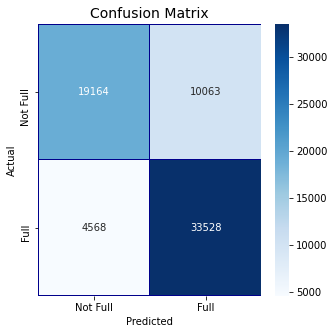

In [ ]:
cm = pd.crosstab(y_train, y_NB_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

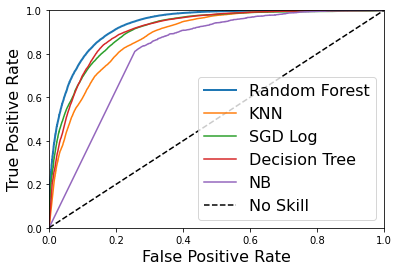

In [55]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_knn_scores)

#for SGD Log
fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_log_scores)

#for tree
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_train, y_tree_scores)

#for NB
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_train, y_NB_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)

#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_knn, tpr_knn, label = "KNN")
plt.plot(fpr_log, tpr_log, label = "SGD Log")
plt.plot(fpr_tree, tpr_tree, label = "Decision Tree")
plt.plot(fpr_NB, tpr_NB, label="NB")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

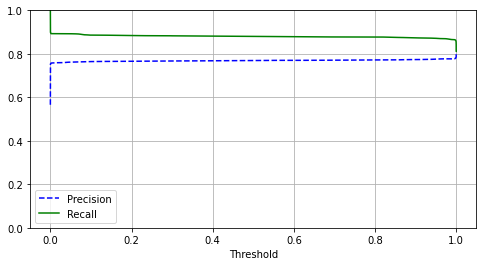

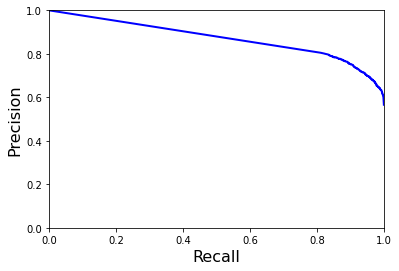

In [56]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_NB_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve
   
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Training: MLP Classifier

In [ ]:
#Fit MLP model
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier()
mlp_clf.fit(X_train_prepared, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
#check fit on train set
from sklearn.metrics import accuracy_score
y_mlp_pred = MLP_clf.predict(X_train_prepared)
accuracy_score(y_train, y_mlp_pred)

0.8939589739019355

In [ ]:
#time-series cross-validation accuracy pre tuning for reference
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(mlp_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([0.83458111, 0.84135472, 0.85109923])

Text(0, 0.5, 'loss function')

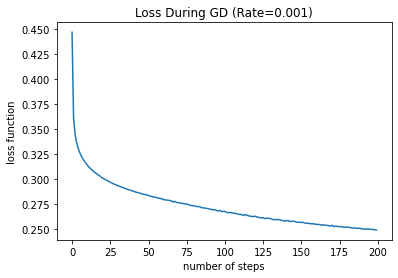

In [ ]:
#Look at loss function after seeing that model did not converge
plt.plot(mlp_clf.loss_curve_)
plt.title('Loss During GD (Rate=0.001)')
plt.xlabel('number of steps')
plt.ylabel('loss function')

In [ ]:
#Adjust learning rate to get model to converge
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(MLPClassifier(hidden_layer_sizes= (75,), learning_rate='adaptive',learning_rate_init=0.1), X_train_prepared, y_train, cv=tscv, scoring="accuracy") #hidden layer rule of thumbs (1 is good for most problems, size as mean of input and output)

array([0.84527629, 0.85620915, 0.84937611])

In [ ]:
#Time series based hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.neural_network import MLPClassifier

#Create timeseries cv 
tscv = TimeSeriesSplit(n_splits=3)

# Create the random grid
parameter_grid = {
                  'hidden_layer_sizes': [(50,), (100,), (100, 100)],
                  'activation': ['tanh', 'relu'],
                  'solver': ['sgd', 'adam'],
                  'alpha': [0.0001, 0.05],
                  'learning_rate': ['constant','adaptive'],
                  'learning_rate_init': [0.0001, 0.1, 1]
                 }

mlp_gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid=param_grid, cv=tscv, verbose=2, scoring='accuracy', n_jobs=1) #n_jobs=-1, pre_dispatch='2*n_jobs')
mlp_gridsearch.fit(X_train_prepared, y_train)
print(mlp_gridsearch.best_params_)
print(mlp_gridsearch.best_score_)
mlp_clf = mlp_gridsearch.best_estimator_

In [ ]:
mlp_gridsearch.cv_results_

{'mean_fit_time': array([0.08168681, 0.0842847 , 0.07841404, 0.08126783, 0.08222151,
        0.08183924, 0.08361387, 0.08242273, 0.08298779, 0.13598235,
        0.13795439, 0.13247236, 0.13830098, 0.13251114, 0.13632703,
        0.1332798 , 0.13970534, 0.1344498 , 0.14241552, 0.14372238,
        0.13639673, 0.13686148, 0.13027946, 0.13660002, 0.13210622,
        0.13303463, 0.13342746, 0.08305852, 0.08480509, 0.0802575 ,
        0.07908201, 0.08173426, 0.08185609, 0.08212431, 0.08058858,
        0.08160424, 0.13194474, 0.13653469, 0.13851039, 0.13555447,
        0.13578693, 0.13282537, 0.13393227, 0.1362861 , 0.13364236,
        0.14346433, 0.14059114, 0.14001155, 0.1313196 , 0.13692411,
        0.13243898, 0.13145693, 0.1359787 , 0.13423642, 0.08897169,
        0.08294026, 0.08365186, 0.08237267, 0.08147152, 0.08320999,
        0.08383314, 0.08348179, 0.08378069, 0.14383173, 0.14219721,
        0.1412584 , 0.14656536, 0.14194735, 0.13765136, 0.13893787,
        0.13713257, 0.14092104,

In [57]:
#Fit tuned MLP model
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(hidden_layer_sizes= (75,), learning_rate='adaptive', learning_rate_init=0.1)
mlp_clf.fit(X_train_prepared, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(75,), learning_rate='adaptive',
              learning_rate_init=0.1, max_fun=15000, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [58]:
#evaluate MLP model
from sklearn.model_selection import cross_val_predict

y_mlp_pred = cross_val_predict(mlp_clf, X_train_prepared, y_train, cv=3)
y_probas_mlp = cross_val_predict(mlp_clf, X_train_prepared, y_train, cv=3, method="predict_proba")
y_mlp_scores = y_probas_mlp[:, 1]
evaluate_model(y_train, y_mlp_pred, y_mlp_scores)

AUC:0.923
accuracy:0.853
recall:0.912
precision:0.841
f1:0.875
prevalence:0.566



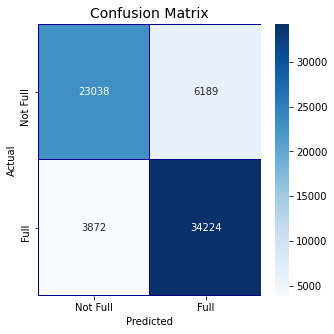

In [ ]:
cm = pd.crosstab(y_train, y_mlp_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

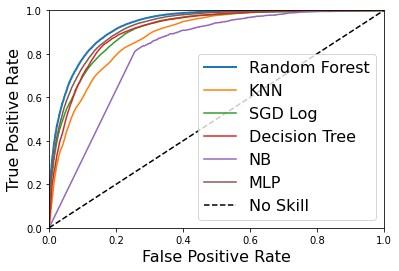

In [59]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_knn_scores)

#for SGD Log
fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_log_scores)

#for tree
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_train, y_tree_scores)

#for NB
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_train, y_NB_scores)

#for MLP
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_train, y_mlp_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)

#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_knn, tpr_knn, label = "KNN")
plt.plot(fpr_log, tpr_log, label = "SGD Log")
plt.plot(fpr_tree, tpr_tree, label = "Decision Tree")
plt.plot(fpr_NB, tpr_NB, label="NB")
plt.plot(fpr_mlp, tpr_mlp, label="MLP")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

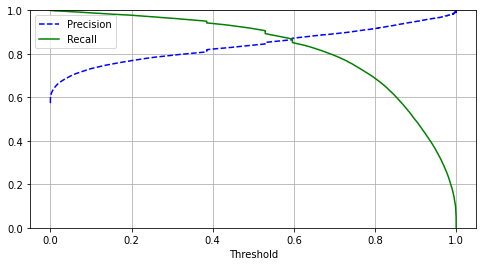

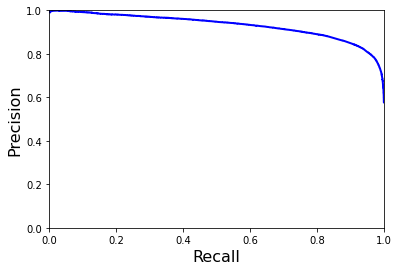

In [60]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_mlp_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve
 
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Training: SVM Classifer

In [ ]:
# fit untuned SGD SVM classifier, SVM with rbf kernel very, very slow but higher accuracy ~85%. Time permitting could try rbf kernel transformation: https://scikit-learn.org/stable/modules/kernel_approximation.html
from sklearn.linear_model import SGDClassifier

svm_clf = SGDClassifier(loss='hinge', random_state=123)
svm_clf.fit(X_train_prepared, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
#check fit on train set
from sklearn.metrics import accuracy_score
y_svm_pred = svm_clf.predict(X_train_prepared)
accuracy_score(y_train, y_svm_pred)

0.8230768088171947

In [ ]:
#time-series cross-validation accuracy pre tuning for reference
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(svm_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

array([0.82626263, 0.82531194, 0.82329174])

In [ ]:
#Time series based hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform
from sklearn.linear_model import SGDClassifier

#The penalty (aka regularization term) to be used. Defaults to ‘l2’ which is the standard regularizer for linear SVM models. ‘l1’ and ‘elasticnet’ might bring sparsity to the model (feature selection) not achievable with ‘l2’.
penalty = ['l2', 'l1', 'elasticnet']

#Constant that multiplies the regularization term. The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’ (default=0.0001).
alpha = [0.000001, 0.0001, 0.01]

#The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1. Only used if penalty is ‘elasticnet’ (default=0.15)
l1_ratio = [0.05, 0.15, 0.5]

#Whether the intercept should be estimated or not. If False, the data is assumed to be already centered (default=True).
fit_intercept = [True]

#The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method, and not the partial_fit method (default=1000).
max_iter = [500, 1000, 5000] 

#The stopping criterion. If it is not None, training will stop when (loss > best_loss - tol) for n_iter_no_change consecutive epochs (default=1e-3)
tol = [1e-3]

#Number of iterations with no improvement to wait before early stopping (default=5).
n_iter_no_change = [5, 20]

#Whether or not the training data should be shuffled after each epoch (default=True).
shuffle = [True, False]

#The learning rate schedul (default=’optimal’)
learning_rate = ['optimal', 'adaptive', 'invscaling']

#The initial learning rate for the ‘constant’, ‘invscaling’ or ‘adaptive’ schedules. The default value is 0.0 as eta0 is not used by the default schedule ‘optimal’.
eta0 = [0.01, 1, 10]

#Whether to use early stopping to terminate training when validation score is not improving (default=False)
early_stopping = [True, False]

#The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True (default=0.1)
validation_fraction = [0.1, 0.3] 

#Create timeseries cv 
tscv = TimeSeriesSplit(n_splits=3)

# Create the random grid
random_grid = {'penalty':penalty,
          'alpha':alpha,
          'l1_ratio': l1_ratio,
          'fit_intercept': fit_intercept,
          'max_iter':max_iter,
          'tol': tol,
          'n_iter_no_change': n_iter_no_change,
          'shuffle': shuffle,
          'learning_rate': learning_rate,
          'eta0': eta0,
          'early_stopping': early_stopping,
          'validation_fraction': validation_fraction
          }

svm_randsearch = RandomizedSearchCV(SGDClassifier(loss='hinge', random_state=123), param_distributions=random_grid, n_iter=1500, cv=tscv, verbose=2, scoring='accuracy', n_jobs=-1, pre_dispatch='2*n_jobs')
svm_randsearch.fit(X_train_prepared, y_train)
print(svm_randsearch.best_params_)
print(svm_randsearch.best_score_)
svm_clf = svm_randsearch.best_estimator_

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed: 29.1min finished


{'validation_fraction': 0.3, 'tol': 0.001, 'shuffle': True, 'penalty': 'elasticnet', 'n_iter_no_change': 5, 'max_iter': 5000, 'learning_rate': 'invscaling', 'l1_ratio': 0.5, 'fit_intercept': True, 'eta0': 1, 'early_stopping': True, 'alpha': 0.0001}
0.838562091503268


In [ ]:
svm_randsearch.cv_results_

{'mean_fit_time': array([0.80553102, 0.50896295, 2.57840546, ..., 0.45960251, 3.05188076,
        0.09707403]),
 'mean_score_time': array([0.00309046, 0.00268865, 0.00296307, ..., 0.00301353, 0.00269198,
        0.00285419]),
 'mean_test_score': array([0.80170331, 0.81018023, 0.82374728, ..., 0.75618934, 0.82626263,
        0.77534165]),
 'param_alpha': masked_array(data=[0.01, 0.01, 1e-06, ..., 1e-06, 0.0001, 1e-06],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_early_stopping': masked_array(data=[False, True, False, ..., True, True, True],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_eta0': masked_array(data=[10, 0.01, 0.01, ..., 0.01, 1, 10],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[True, True, True, 

In [61]:
#fit tuned model, hardcoded since often disconnected and slow to re-run tuning
from sklearn.linear_model import SGDClassifier

svm_clf = SGDClassifier(loss='hinge', validation_fraction=0.6, penalty='elasticnet', max_iter=5000, learning_rate='invscaling', eta0=1, l1_ratio=0.5, early_stopping=True, random_state=123)
svm_clf.fit(X_train_prepared, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=True, epsilon=0.1, eta0=1, fit_intercept=True,
              l1_ratio=0.5, learning_rate='invscaling', loss='hinge',
              max_iter=5000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=123, shuffle=True,
              tol=0.001, validation_fraction=0.6, verbose=0, warm_start=False)

In [62]:
#evaluate tuned model
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import CalibratedClassifierCV

y_svm_pred = cross_val_predict(svm_clf, X_train_prepared, y_train, cv=3)
#No probability function for svm, can estimate using calibrated classifier
svm_proba_model = CalibratedClassifierCV(svm_clf)
svm_proba_model.fit(X_train_prepared, y_train)
#svm_proba_model.predict_proba(X_train_prepared)
y_probas_svm = cross_val_predict(svm_proba_model, X_train_prepared, y_train, cv=3, method="predict_proba")
y_svm_scores = y_probas_svm[:, 1]
evaluate_model(y_train, y_svm_pred, y_svm_scores)

AUC:0.904
accuracy:0.837
recall:0.905
precision:0.824
f1:0.863
prevalence:0.566



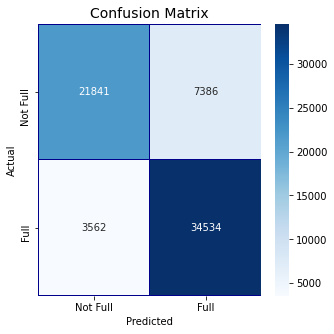

In [ ]:
cm = pd.crosstab(y_train, y_svm_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

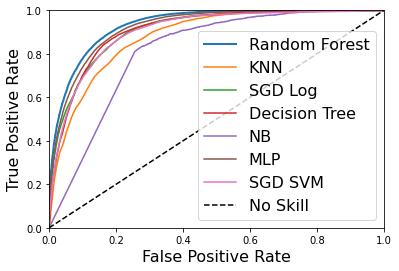

In [63]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_knn_scores)

#for SGD Log
fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_log_scores)

#for tree
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_train, y_tree_scores)

#for NB
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_train, y_NB_scores)

#for MLP
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_train, y_mlp_scores)

#for SGD SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_svm_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)

#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_knn, tpr_knn, label = "KNN")
plt.plot(fpr_log, tpr_log, label = "SGD Log")
plt.plot(fpr_tree, tpr_tree, label = "Decision Tree")
plt.plot(fpr_NB, tpr_NB, label="NB")
plt.plot(fpr_mlp, tpr_mlp, label="MLP")
plt.plot(fpr_svm, tpr_svm, label="SGD SVM")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

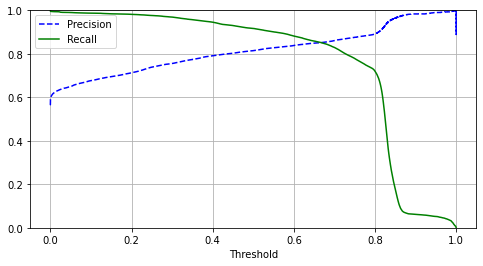

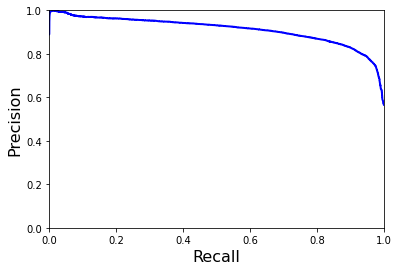

In [64]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train,y_svm_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve
  
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Training: AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), random_state=123)
ada_clf.fit(X_train_prepared, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
#check fit on train set
from sklearn.metrics import accuracy_score
y_ada_pred = ada_clf.predict(X_train_dense)
accuracy_score(y_train, y_ada_pred)

0.846516049492744

In [ ]:
#time-series cross-validation accuracy pre tuning for reference
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(ada_clf, X_train_dense, y_train, cv=tscv, scoring="accuracy")

array([0.84753417, 0.84218657, 0.84836601])

In [ ]:
#Time series based hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import AdaBoostClassifier

#Create timeseries cv 
tscv = TimeSeriesSplit(n_splits=3)

#The base estimator from which the boosted ensemble is built. Support for sample weighting is required, as well as proper classes_ and n_classes_ attributes. If None, then the base estimator is DecisionTreeClassifier(max_depth=1).
base_estimator = [tree_clf, None]

#The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.
n_estimators = [25, 50, 100]

#Learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators (Default=1)
learning_rate = [0.1, 0.5, 1.0]

#If ‘SAMME.R’ then use the SAMME.R real boosting algorithm. base_estimator must support calculation of class probabilities. If ‘SAMME’ then use the SAMME discrete boosting algorithm. The SAMME.R algorithm typically converges faster than SAMME, achieving a lower test error with fewer boosting iterations (default=’SAMME.R’)
algorithm = ['SAMME', 'SAMME.R'] 

#Create the param grid
param_grid = {
                  'base_estimator': base_estimator,
                  'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'algorithm': algorithm,
                 }

ada_gridsearch = GridSearchCV(AdaBoostClassifier(random_state=123), param_grid=param_grid, cv=tscv, verbose=2, scoring='accuracy', n_jobs=-1, pre_dispatch='2*n_jobs')
ada_gridsearch.fit(X_train_dense, y_train)
print(ada_gridsearch.best_params_)
print(ada_gridsearch.best_score_)
ada_clf = ada_gridsearch.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 11.5min finished


{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best'), 'learning_rate': 0.1, 'n_estimators': 100}
0.8603683897801545


In [ ]:
ada_gridsearch.cv_results_

{'mean_fit_time': array([ 5.68476478, 14.14467255, 26.79465524,  6.71508972, 12.8059512 ,
        25.39479041,  5.74793633, 11.02061224, 21.71070449,  3.91776705,
         7.84883285, 16.14510425,  4.02733072,  7.96962007, 16.0844303 ,
         4.11777472,  8.10233243, 16.04292083,  5.52432593, 10.88487641,
        22.33524354,  6.34876084, 12.4556667 , 23.79751404,  6.12629422,
        11.57772764, 22.9903597 ,  4.25045379,  8.57701898, 16.97829755,
         4.28044605,  8.54853908, 18.73585248,  4.23532287,  8.38298615,
        15.54734445]),
 'mean_score_time': array([0.34431227, 0.69670065, 1.42765609, 0.35534247, 0.73249197,
        1.4039522 , 0.34877316, 0.68356299, 1.3781902 , 0.26791867,
        0.53907887, 1.08818324, 0.27303513, 0.54893184, 1.10596752,
        0.28127456, 0.56242967, 1.07145834, 0.41849566, 0.82726018,
        1.71469458, 0.42593328, 0.86837554, 1.70925824, 0.43244004,
        0.82979306, 1.67856566, 0.35247072, 0.69628867, 1.39507731,
        0.35733398, 0.

In [65]:
#Fit tuned Adaboost model
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(tree_clf, algorithm='SAMME', n_estimators=100, learning_rate=0.1)
ada_clf.fit(X_train_dense, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=50,
                                                         max_features='sqrt',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=20,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                        

In [66]:
#Evaluate tuned Adaboost model
from sklearn.model_selection import cross_val_predict

y_ada_pred = cross_val_predict(ada_clf, X_train_dense, y_train, cv=3)
y_probas_ada = cross_val_predict(ada_clf, X_train_dense, y_train, cv=3, method="predict_proba")
y_ada_scores = y_probas_ada[:, 1]
evaluate_model(y_train, y_ada_pred, y_ada_scores)

AUC:0.933
accuracy:0.863
recall:0.908
precision:0.857
f1:0.882
prevalence:0.566



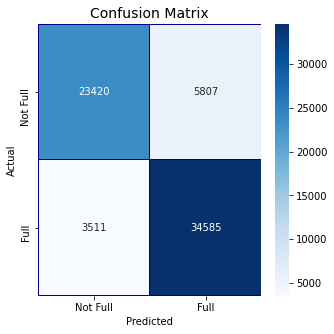

In [ ]:
cm = pd.crosstab(y_train, y_ada_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

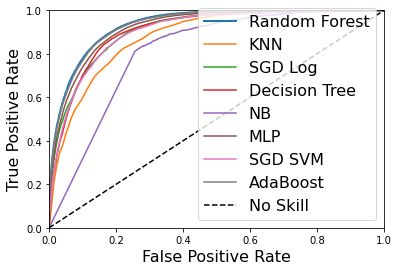

In [67]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_knn_scores)

#for SGD Log
fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_log_scores)

#for tree
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_train, y_tree_scores)

#for NB
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_train, y_NB_scores)

#for MLP
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_train, y_mlp_scores)

#for SGD SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_svm_scores)

#for AdaBoost
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_train, y_ada_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)
 
#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_knn, tpr_knn, label = "KNN")
plt.plot(fpr_log, tpr_log, label = "SGD Log")
plt.plot(fpr_tree, tpr_tree, label = "Decision Tree")
plt.plot(fpr_NB, tpr_NB, label="NB")
plt.plot(fpr_mlp, tpr_mlp, label="MLP")
plt.plot(fpr_svm, tpr_svm, label="SGD SVM")
plt.plot(fpr_ada, tpr_ada, label="AdaBoost")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

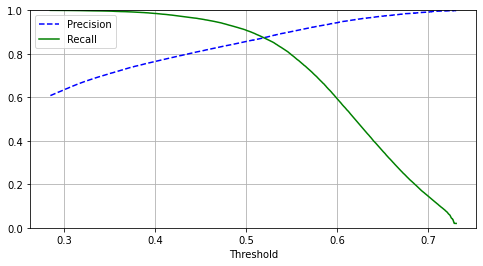

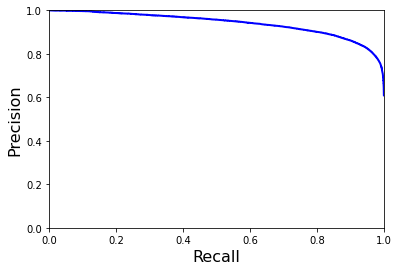

In [68]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_ada_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve
   
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Training: XGBoost

In [ ]:
import xgboost
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_prepared, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#check fit on train set
from sklearn.metrics import accuracy_score
y_xgb_pred = xgb_clf.predict(X_train_prepared)
accuracy_score(y_train, y_xgb_pred)

0.8493234110185226

In [ ]:
#time-series cross-validation accuracy pre tuning for reference
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(xgb_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

array([0.84806892, 0.84723708, 0.8483066 ])

In [ ]:
#Time series based hyperparameter tuning 
#https://xgboost.readthedocs.io/en/latest/parameter.html
#http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
import xgboost
from xgboost import XGBClassifier

#Create timeseries cv 
tscv = TimeSeriesSplit(n_splits=3)

#Create the param grid
param_grid = {"learning_rate"    : [0.1, 0.3, 0.5] ,
              "max_depth"        : [3, 6, 10],
              "min_child_weight" : [0.5, 1, 5],
              "gamma"            : [0, 0.1, 0.5],
              "colsample_bytree" : [0.3, 0.5, 1],
              'reg_alpha'        : [0.01, 0, 10],
              }

xgb_gridsearch = GridSearchCV(XGBClassifier(seed=123), param_grid=param_grid, cv=tscv, verbose=2, scoring='accuracy', n_jobs=-1, pre_dispatch='2*n_jobs')
xgb_gridsearch.fit(X_train_prepared, y_train)
print(xgb_gridsearch.best_params_)
print(xgb_gridsearch.best_score_)
xgb_clf = xgb_gridsearch.best_estimator_

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 72.8min
[Parallel(n_jobs=-1)]: Done 2187 out of 2187 | elapsed: 83.8min finished


{'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 0.5, 'reg_alpha': 0.01}
0.86232917409388


In [ ]:
ada_gridsearch.cv_results_

{'mean_fit_time': array([ 5.68476478, 14.14467255, 26.79465524,  6.71508972, 12.8059512 ,
        25.39479041,  5.74793633, 11.02061224, 21.71070449,  3.91776705,
         7.84883285, 16.14510425,  4.02733072,  7.96962007, 16.0844303 ,
         4.11777472,  8.10233243, 16.04292083,  5.52432593, 10.88487641,
        22.33524354,  6.34876084, 12.4556667 , 23.79751404,  6.12629422,
        11.57772764, 22.9903597 ,  4.25045379,  8.57701898, 16.97829755,
         4.28044605,  8.54853908, 18.73585248,  4.23532287,  8.38298615,
        15.54734445]),
 'mean_score_time': array([0.34431227, 0.69670065, 1.42765609, 0.35534247, 0.73249197,
        1.4039522 , 0.34877316, 0.68356299, 1.3781902 , 0.26791867,
        0.53907887, 1.08818324, 0.27303513, 0.54893184, 1.10596752,
        0.28127456, 0.56242967, 1.07145834, 0.41849566, 0.82726018,
        1.71469458, 0.42593328, 0.86837554, 1.70925824, 0.43244004,
        0.82979306, 1.67856566, 0.35247072, 0.69628867, 1.39507731,
        0.35733398, 0.

In [69]:
#Fit tuned xgboost model
import xgboost
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=10, min_child_weight=0.5, reg_alpha=0.01, seed=123)
xgb_clf.fit(X_train_prepared, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=0.5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=1, verbosity=1)

In [70]:
#Evaluate tuned XGB model
from sklearn.model_selection import cross_val_predict

y_xgb_pred = cross_val_predict(xgb_clf, X_train_prepared, y_train, cv=3)
y_probas_xgb = cross_val_predict(xgb_clf, X_train_prepared, y_train, cv=3, method="predict_proba")
y_xgb_scores = y_probas_xgb[:, 1]
evaluate_model(y_train, y_xgb_pred, y_xgb_scores)

AUC:0.934
accuracy:0.863
recall:0.915
precision:0.854
f1:0.883
prevalence:0.566



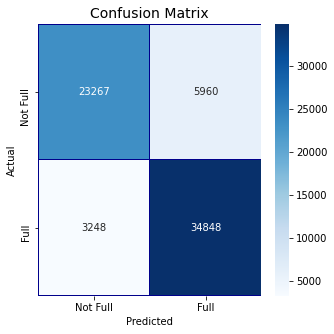

In [ ]:
cm = pd.crosstab(y_train, y_xgb_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

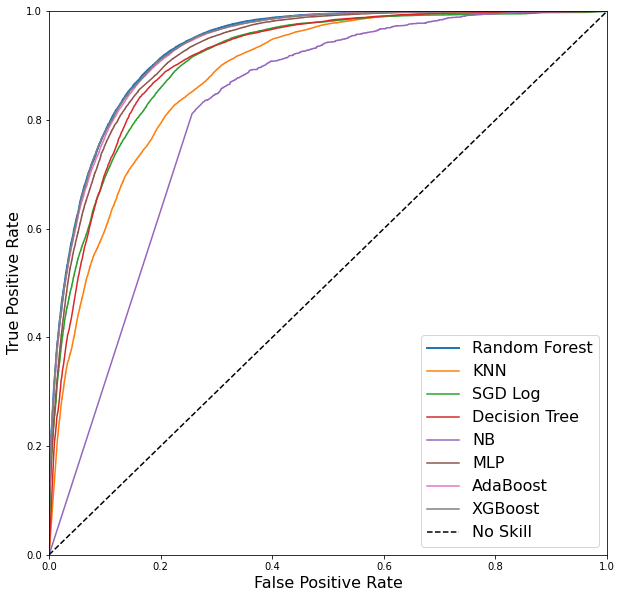

In [ ]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_knn_scores)

#for SGD Log
fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_log_scores)

#for tree
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_train, y_tree_scores)

#for NB
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_train, y_NB_scores)

#for MLP
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_train, y_mlp_scores)

#for SGD SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_svm_scores)

#for AdaBoost
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_train, y_ada_scores)

#for XGB
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train, y_xgb_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)
   
#Plot the Roc Curve
plt.figure(figsize=(10, 10))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_knn, tpr_knn, label = "KNN")
plt.plot(fpr_log, tpr_log, label = "SGD Log")
plt.plot(fpr_tree, tpr_tree, label = "Decision Tree")
plt.plot(fpr_NB, tpr_NB, label="NB")
plt.plot(fpr_mlp, tpr_mlp, label="MLP")
plt.plot(fpr_svm, tpr_svm, label="SGD SVM")
plt.plot(fpr_ada, tpr_ada, label="AdaBoost")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

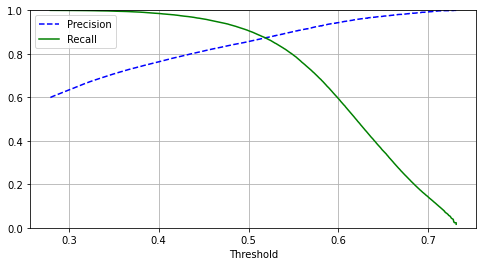

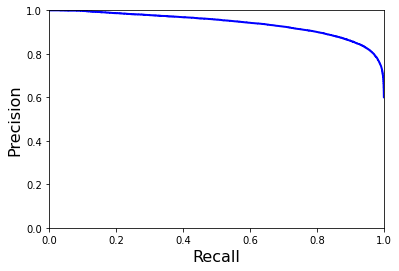

In [ ]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_ada_scores)

plt.show()

#plot the precision and recall curve
  
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Training: Bagging/Voting Classifier

Text(0.5, 1.05, 'Model Probability Output Heatmap')

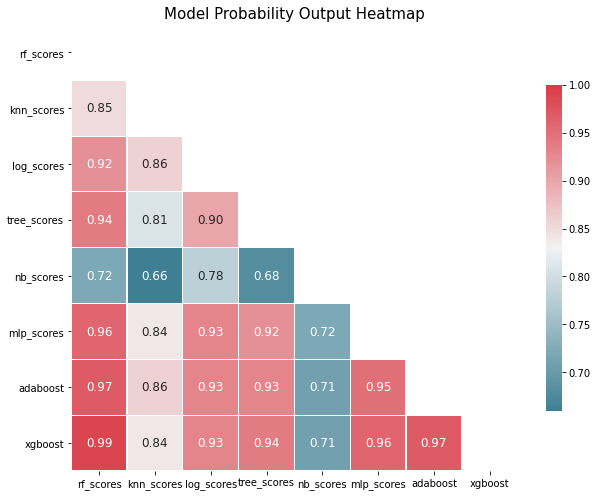

In [81]:
#df with all probability scores
df_scores = pd.DataFrame(data=y_forest_scores, columns=['rf_scores'])
df_scores['rf_scores'] = y_forest_scores
df_scores['knn_scores'] = y_knn_scores
df_scores['log_scores'] = y_log_scores
df_scores['tree_scores'] = y_tree_scores
df_scores['nb_scores'] = y_NB_scores
df_scores['mlp_scores'] = y_mlp_scores
df_scores['adaboost'] = y_ada_scores
df_scores['xgboost'] = y_xgb_scores

#Look at correlation between scores, see if models are producing similar estimates
corr = df_scores.corr()
    
_ , ax = plt.subplots(figsize =(10, 10))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
    
_ = sns.heatmap(round(corr,2), 
                cmap = colormap,
                square=True, 
                cbar_kws={'shrink':.6 }, 
                ax=ax,
                annot=True, 
                linewidths=0.1,vmax=1.0, linecolor='white',
                annot_kws={'fontsize':12 },
                fmt=".2f",
                mask=mask)
    
plt.title('Model Probability Output Heatmap', y=1.05, size=15)

#Some models highly correlated (most except NB) but still some variance which might support improved accuracy from voting classifer 

In [72]:
from sklearn.ensemble import VotingClassifier

models = [('rf',forest_clf), ('knn',knn_clf), ('lr',log_clf), ('tree',tree_clf), ('nb',NB_clf), ('mlp',mlp_clf),('ada',ada_clf),('xgb',xgb_clf) ]
voting_clf = VotingClassifier(estimators=models, voting='soft', n_jobs=-1)
voting_clf.fit(X_train_dense, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=10,
                                                     min_weight_fraction_leaf=0.0,
       

In [ ]:
#check fit on train set
from sklearn.metrics import accuracy_score
y_voting_pred = voting_clf.predict(X_train_dense)
accuracy_score(y_train, y_voting_pred)

0.9060647921215632

In [76]:
#evaluate voting model
from sklearn.model_selection import cross_val_predict

y_voting_pred = cross_val_predict(voting_clf, X_train_dense, y_train, cv=3)
y_probas_voting = cross_val_predict(voting_clf, X_train_dense, y_train, cv=3, method="predict_proba")
y_voting_scores = y_probas_voting[:, 1]
evaluate_model(y_train, y_voting_pred, y_voting_scores)

AUC:0.928
accuracy:0.856
recall:0.931
precision:0.834
f1:0.880
prevalence:0.566



In [ ]:
#evaluate hard voting model. Slightly outpeforming soft voting, keep soft voting to use probabilities.
from sklearn.model_selection import cross_val_predict

y_hvoting_pred = cross_val_predict(VotingClassifier(estimators=models, voting='hard', n_jobs=-1), X_train_dense, y_train, cv=3)
accuracy_score(y_train, y_hvoting_pred)

0.8579237407720987

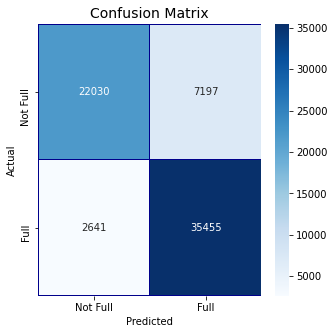

In [ ]:
cm = pd.crosstab(y_train, y_voting_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

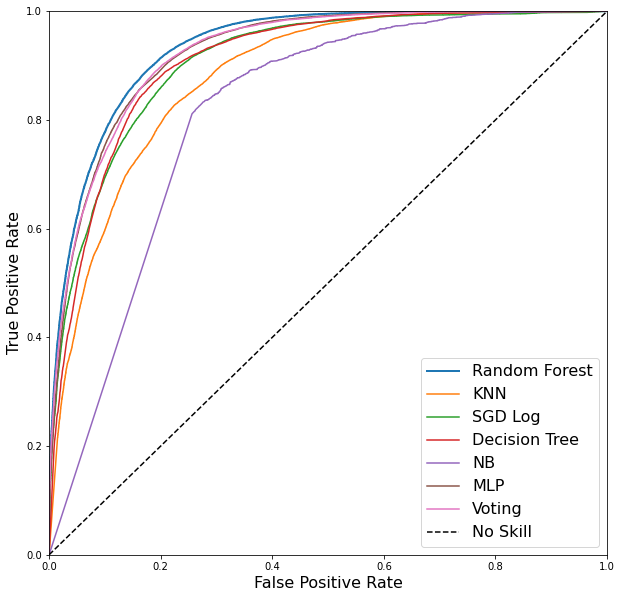

In [ ]:
from sklearn.metrics import roc_curve

#for random forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_forest_scores)

#for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_knn_scores)

#for SGD Log
fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_log_scores)

#for tree
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_train, y_tree_scores)

#for NB
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_train, y_NB_scores)

#for MLP
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_train, y_mlp_scores)

#for SGD SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_svm_scores)

#for AdaBoost
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_train, y_ada_scores)

#for XGB
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train, y_xgb_scores)

#for Voting
fpr_voting, tpr_voting, thresholds_voting = roc_curve(y_train, y_voting_scores)

#for no skill
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_train, ns_probs)

#Plot the Roc Curve
plt.figure(figsize=(10, 10))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_knn, tpr_knn, label = "KNN")
plt.plot(fpr_log, tpr_log, label = "SGD Log")
plt.plot(fpr_tree, tpr_tree, label = "Decision Tree")
plt.plot(fpr_NB, tpr_NB, label="NB")
plt.plot(fpr_mlp, tpr_mlp, label="MLP")
plt.plot(fpr_svm, tpr_svm, label="SGD SVM")
plt.plot(fpr_ada, tpr_ada, label="AdaBoost")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot(fpr_voting, tpr_voting, label="Voting")
plt.plot(fpr_ns, tpr_ns, 'k--', label="No Skill")
plt.legend(loc="lower right", fontsize=16)
plt.show()

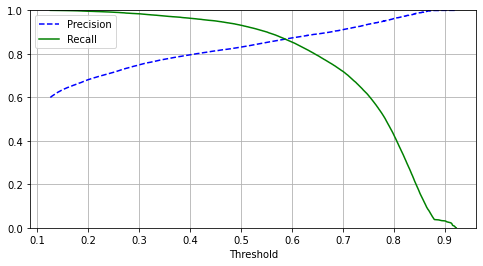

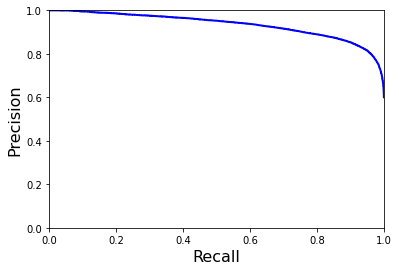

In [ ]:
#create threshold and precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_voting_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Training: Stacking

In [82]:
df_scores['rf_pred'] = y_forest_pred
df_scores['knn_pred'] = y_knn_pred
df_scores['log_pred'] = y_log_pred
df_scores['tree_pred'] = y_tree_pred
df_scores['nb_pred'] = y_NB_pred
df_scores['mlp_pred'] = y_mlp_pred
df_scores['svm_pred'] = y_svm_pred
df_scores['voting_pred'] = y_voting_pred
df_scores

rf_scores  knn_scores  log_scores  ...  mlp_pred  svm_pred  voting_pred
0       0.858014    0.864257    0.823870  ...         1         1            1
1       0.004394    0.000000    0.055040  ...         0         0            0
2       0.844200    0.911568    0.570972  ...         1         1            1
3       0.847238    0.614650    0.793366  ...         1         1            1
4       0.099277    0.263303    0.423192  ...         0         0            0
...          ...         ...         ...  ...       ...       ...          ...
67318   0.185239    0.397597    0.392450  ...         0         0            0
67319   0.000000    0.000000    0.000029  ...         0         0            0
67320   0.570111    0.726171    0.632059  ...         1         1            1
67321   0.701402    0.753752    0.754112  ...         1         1            1
67322   0.914344    0.809450    0.922054  ...         1         1            1

[67323 rows x 16 columns]

In [86]:
from sklearn.ensemble import RandomForestClassifier

X_clf_preds = df_scores.values

rf_blender_clf= RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123)
rf_blender_clf.fit(X_clf_preds, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123, verbose=0,
                       warm_start=False)

In [88]:
rf_blender_clf.oob_score_

0.861444083002837

In [144]:
#evaluate stacking model
from sklearn.model_selection import cross_val_predict

y_stacking_pred = cross_val_predict(rf_blender_clf, X_train_dense, y_train, cv=3)
y_probas_stacking = cross_val_predict(rf_blender_clf, X_train_dense, y_train, cv=3, method="predict_proba")
y_stacking_scores = y_probas_stacking[:, 1]
evaluate_model(y_train, y_stacking_pred, y_stacking_scores)

AUC:0.932
accuracy:0.863
recall:0.907
precision:0.858
f1:0.882
prevalence:0.566



# Training Model Comparison

In [147]:
#Organize results into a table

from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, recall_score

models = [forest_clf, knn_clf, log_clf, tree_clf, NB_clf, mlp_clf, svm_clf, ada_clf, xgb_clf,voting_clf, rf_blender_clf]
preds = [y_forest_pred, y_knn_pred, y_log_pred, y_tree_pred, y_NB_pred, y_mlp_pred, y_svm_pred, y_ada_pred, y_xgb_pred, y_voting_pred, y_stacking_pred]
scores = [y_forest_scores, y_knn_scores, y_log_scores, y_tree_scores, y_NB_scores, y_mlp_scores, y_svm_scores, y_ada_scores, y_xgb_scores, y_voting_scores, y_stacking_scores]

model_name = []
auc = []
accuracy = []
recall = []
precision = []
f1score = []


model = 0

for pred in preds:
 
  if model == 10:
    model_name.append('StackingClassifier')
  elif model == 2:
    model_name.append('SGD Log')
  elif model == 6:
    model_name.append('SGD SVM')
  else:
    model_name.append(type(models[model]).__name__)

  auc.append(roc_auc_score(y_train, scores[model]))
  accuracy.append(accuracy_score(y_train, preds[model]))
  recall.append(recall_score(y_train, preds[model]))
  precision.append(precision_score(y_train, preds[model]))
  f1score.append(f1_score(y_train, preds[model]))

  model+=1


results = pd.DataFrame({'Model':model_name, 'AUC':auc,'Accuracy':accuracy,'Recall':recall, 'Precision':precision,'F1 Score':f1score})
results.sort_values('Accuracy', ascending=False)


Model       AUC  Accuracy    Recall  Precision  F1 Score
0   RandomForestClassifier  0.934642  0.864549  0.912957   0.857009  0.884099
8            XGBClassifier  0.933822  0.863241  0.915135   0.853711  0.883357
7       AdaBoostClassifier  0.932559  0.862573  0.908179   0.857405  0.882062
10      StackingClassifier  0.932489  0.862528  0.906814   0.858264  0.881872
9         VotingClassifier  0.927957  0.856186  0.931436   0.833858  0.879950
5            MLPClassifier  0.923169  0.852532  0.911854   0.840951  0.874969
3   DecisionTreeClassifier  0.908992  0.845833  0.883951   0.849671  0.866472
2                  SGD Log  0.908841  0.840827  0.905817   0.828802  0.865600
6                  SGD SVM  0.903860  0.836980  0.905161   0.824065  0.862711
1     KNeighborsClassifier  0.881195  0.809486  0.900777   0.791384  0.842545
4               GaussianNB  0.812904  0.782675  0.880092   0.769150  0.820889

# Final Model Evaluation

In [ ]:
#final_clf =

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# prepare data pipeline
# numerical values scaled using standard scaler and built in median imputer just in case despite no null values observed
num_X = X_test.select_dtypes(include=['int64', 'float64']).columns
cat_X = X_test.select_dtypes(include=['object', 'bool']).columns

# create pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),                 
        ('std_scaler', StandardScaler()),
    ])

preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_X),
        ("cat", OneHotEncoder(), cat_X),
       ])

#pipeline = ...preprocessor and model or combine into pipeline above 

X_test_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.fit_transform(X_test)

In [ ]:
#evaluate final model
from sklearn.model_selection import cross_val_predict

y_test_pred = cross_val_predict(final_clf, X_test_dense, y_test, cv=3)
y_probas_test = cross_val_predict(final_clf, X_test_dense, y_test, cv=3, method="predict_proba")
y_test_scores = y_probas_test[:, 1]
evaluate_model(y_test, y_test_pred, y_test_scores)

In [ ]:
#Notes: removing some features had limited impact on accuracy, hyperparameter accuracy vs time, balanced, cleaning

# PCA Test NOT USED - Loss in accuracy didn't seem to make up for any minor gains in speed

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# prepare data pipeline
# numerical values scaled using standard scaler and built in median imputer just in case despite no null values observed
num_X = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_X = X_train.select_dtypes(include=['object', 'bool']).columns
#date_X = X_train.select_dtypes(include=['datetime64[ns]']).columns

# create pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),                 
        ('std_scaler', StandardScaler()),
    ])

preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_X),
        ("cat", OneHotEncoder(sparse=False), cat_X),
        #('date', SimpleImputer(), date_X)
    ])

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.fit_transform(X_test)

In [ ]:
#Look at elbow method to see where gains in unexplained variance start to dimish, i.e. a good place to cut-off
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(random_state=123).fit(X_train_prepared)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance')

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
px.line(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Cumulative Explained Variance"}
)

In [ ]:
#can set explained variance target, e.g. 90% 
pca = PCA(n_components=0.9, random_state=123).fit(X_train_prepared)
pca.n_components_

12

In [ ]:
#fit PCA on X_train
X_train_pca = pca.transform(X_train_prepared)

In [ ]:
#evaluate model with PCA dim reduction, note accuracy is ~3% lower, speed was not noticeably improved
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict 
y_forest_pred = cross_val_predict(RandomForestClassifier(random_state=123), X_train_pca, y_train, cv=3)
y_probas_forest = cross_val_predict(RandomForestClassifier(random_state=123), X_train_pca, y_train, cv=3, method="predict_proba")
y_forest_scores = y_probas_forest[:, 1]
evaluate_model(y_train, y_forest_pred, y_forest_scores)

AUC:0.902
accuracy:0.834
recall:0.866
precision:0.844
f1:0.855
prevalence:0.566



In [ ]:
# example to evaluate PCA hyperparameters, data was too large for kernel PCA it seems, would need to try another strategy (batch?)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import KernelPCA, PCA

pipe = Pipeline([
        #('kpca', KernelPCA()), #kpca kept crashing, not enough RAM?
        ('pca', PCA()),
        ('rf', RandomForestClassifier(max_features='sqrt', min_samples_leaf=5 ,random_state=123))
    ])

param_grid = [{
        'pca__n_components': [5, 10, 20]
        #'kpca__n_components': [10, 20],
        #'kpca__gamma': [0.01, 0.05], #np.linspace(0.03, 0.05, 10),
        #'kpca__kernel': ['linear', 'rbf', 'sigmoid']
    }]

estimator = RandomizedSearchCV(pipe, param_distributions=param_grid, verbose=2, n_iter=1, n_jobs=-1, pre_dispatch='2*n_jobs', cv=3)
estimator.fit(X_train_prepared, y_train)

print("The best parameters: {0}".format(estimator.best_params_))
print("The best score: {0}".format(estimator.best_score_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   45.8s finished


The best parameters: {'pca__n_components': 10}


In [ ]:
print("The best score: {0}".format(estimator.best_score_))

The best score: 0.8206259376438959


In [ ]:
#pipe.set_params(**estimator.best_params_)